# 1. 狮子、老虎和熊

我们参观野生动物园保护区，看到了3只狮子、2只老虎和1头熊，如果我们观察到任何动物的机会均等，那么动物园所有动物中，狮子、老虎和熊的占比各是多少？  
先验分布可以假定每种动物的占比是一样的，但各类动物占比不是独立的，所有的占比之和为1。可以用狄利克雷分布来建模。

## 1.1 狄利克雷分布

**狄利克雷分布**$Dir(\alpha)$ , 是一组$k$个连续多元随机分布的分布族，这组多元连续分布随机变量的参数为$\mathbf{a}=(\alpha_{1}, \alpha_{2}, \cdots, \alpha_{k})$，$\alpha_{i}\geq0$。它是贝塔（$\mathrm {B} $）分布在多元维度上的推广，也被称为多元贝塔布(MBD)。在贝叶斯理论中，狄利克雷分布是分类分布和多项式分布的共轭先验分布，因此常被用作先验分布。狄利克雷分布的密度函数为：

$$f\left( {{x}_{1}},\cdots ,{{x}_{k}};{{\alpha }_{1}},\cdots ,{{\alpha }_{k}} \right)=\dfrac{1}{\mathrm {B}\left( \alpha  \right)}\prod\limits_{i=1}^{K}{x_{i}^{{{\alpha }_{i}}-1}}$$

且对于所有$i\in [1,K]$，满足以下条件：

$$\left\{ \begin{matrix}
   \sum\limits_{i=1}^{k}{{{x}_{i}}=1}  \\
   {{x}_{i}}\ge 0  \\
   {{\alpha }_{i}}\ge 0  \\
\end{matrix} \right.
$$

其中归一化常数$\mathrm {B}$为：

$${\displaystyle \mathrm {B} ({\boldsymbol {\alpha }})={\frac {\prod _{i=1}^{K}\Gamma (\alpha _{i})}{\Gamma \left(\sum _{i=1}^{K}\alpha _{i}\right)}},\qquad {\boldsymbol {\alpha }}=(\alpha _{1},\ldots ,\alpha _{K})}$$

狄利克雷分布的**边缘分布**是贝塔分布：
$${\displaystyle X_{i}\sim \operatorname {Beta} (\alpha _{i},\alpha _{0}-\alpha _{i})}$$其中，$$\displaystyle{\alpha_0 = \sum_1^k \alpha_i}$$

# 1.2 类Dirichlet

In [1]:
from tools import Beta, MakePmfFromItems, MakePmfFromDict
import numpy

class Dirichlet(object):
    """狄利克雷分布模型。
    """
    
    def __init__(self, n, conc=1, name=''):
        """初始化狄利克雷分布
        n: 维度
        conc: 集中度参数 (数值越小，集中度越高)
        name: 实例的名称
        """
        if n < 2:
            raise ValueError('狄利克雷分布的维数应当大于或等于2')

        self.n = n
        self.params = numpy.ones(n, dtype=numpy.float) * conc
        self.name = name

    def Update(self, data):
        """更新分布。
        data: 观测值构成的列表，与对应参数顺序保持一致。"""
        m = len(data)
        self.params[:m] += data

    def Random(self):
        """从分布生成随机变量。gamma抽样。

        Returns:归一化向量（列表）
        """
        p = numpy.random.gamma(self.params)
        return p / p.sum()

    def Likelihood(self, data):
        """似然函数。
        从分布组合中选择一个随机的概率向量。
        
        Returns: 概率值
        """
        m = len(data)
        if self.n < m:
            return 0

        x = data
        p = self.Random()
        q = p[:m] ** x
        return q.prod()

    def LogLikelihood(self, data):
        """对数似然分布.

        Returns: 对数概率值。
        """
        m = len(data)
        if self.n < m:
            return float('-inf')

        x = self.Random()
        y = numpy.log(x[:m]) * data
        return y.sum()

    def MarginalBeta(self, i):
        """计算第i个元分布的边际分布（Beta分布）.

        i: int
        Returns: Beta分布
        """
        alpha0 = self.params.sum()
        alpha = self.params[i]
        # Beta是在tools中定义的一个类
        return Beta(alpha, alpha0 - alpha)

    def PredictivePmf(self, xs, name=''):
        """Makes a predictive distribution.

        xs: values to go into the Pmf

        Returns: Pmf that maps from x to the mean prevalence of x
        """
        alpha0 = self.params.sum()
        ps = self.params / alpha0
        return MakePmfFromItems(zip(xs, ps), name=name)

 Dirichlet类的__init__()方法的初始化功能很简单，只需要指定维度并给出集中度参数即可。狄利克雷分布的边缘分布是Beta分布， Dirichlet类的MarginalBeta（）方法可用于计算随机变量的边缘分布。

# 1.3 种群密度的后验分布

In [8]:
dirichlet = Dirichlet(3)
names = ['狮子','老虎','熊']
for i in range(3):
    beta = dirichlet.MarginalBeta(i)
    print(F"{names[i]}的占比的先验分布均值为:{beta.Mean():.02}。")


狮子的占比的先验分布均值为:0.33。
老虎的占比的先验分布均值为:0.33。
熊的占比的先验分布均值为:0.33。


狄利克雷分布是分类分布和多项式分布的共轭先验分布，因此在Update方法中只需将参数简单相加即可。结果如下：

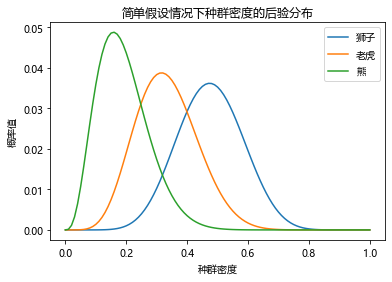

In [11]:
data = [3,2,1]
dirichlet.Update(data)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
for i in range(3):
    beta = dirichlet.MarginalBeta(i)
    beta_pmf = beta.MakePmf()
    
    x,y = zip(*beta_pmf.Items())
    plt.plot(x,y,label=names[i])   

plt.title("简单假设情况下种群密度的后验分布")
plt.xlabel('种群密度')
plt.ylabel('概率值')
plt.legend()
plt.show()

# 2. 分层版本的种群分布

现在，我们将问题升级。前面的例子，我们只假定保护区只有3种动物，这显然不符合现实。现在我们要考虑保护区还有其他动物的情况下，狮子、老虎和熊的占比是多少？
这个问题，我们可以分解为通过两个层次：第一个层次，保护区有多少种动物？第二个层次，各类动物的占比是多少？对此，我们需要编写两个层次的Suite对象，最上层的Suite对象代表种群数量，它的各个假设也是Suite对象，代表各个种群的占比。

In [ ]:
from tools import Suite
class Species(Suite):
    """种群数量"""
    
    def __init__(self, ns, conc=1, iters=1000):
        hypos = [Dirichlet(n, conc) for n in ns]
        Suite.__init__(self, hypos)
        # 不会直接求似然值，而是采用样本抽样，iters为抽样次数
        self.iters = iters

    def Update(self, data):
        """更新数据

        data: 观测到的动物频率构成的列表。
        """
        # 调用父类中的Update方法，它将调用本类中的Likelihood方法
        Suite.Update(self, data)

        # 更新下层的Suite对象
        for hypo in self.Values():
            hypo.Update(data)

    def Likelihood(self, data, hypo):
        """当前假设下的似然函数

        hypo: Dirichlet对象
        data: 观测到的种群频率列表
        """
        dirichlet = hypo

        # draw sample Likelihoods from the hypothetical Dirichlet dist
        # and add them up
        like = 0
        for _ in range(self.iters):
            like += dirichlet.Likelihood(data)

        # correct for the number of ways the observed species
        # might have been chosen from all species
        m = len(data)
        like *= thinkbayes.BinomialCoef(dirichlet.n, m)

        return like

    def DistN(self):
        """Computes the distribution of n."""
        pmf = thinkbayes.Pmf()
        for hypo, prob in self.Items():
            pmf.Set(hypo.n, prob)
        return pmf

狄利克雷分布是分类分布和多项式分布的共轭先验分布。这意味着，如果**随机变量**$X$服从分类分布或多项式分布，并且该**分布的参数**$\mathbf{a}$的先验分布服从狄利克雷分布，则该**参数**$\mathbf{a}$的后验分布也服从狄利克雷分布。即，如果：
$${\displaystyle {\begin{array}{rcccl}{\boldsymbol {\alpha }}&=&\left(\alpha _{1},\ldots ,\alpha _{K}\right)&=&{\text{比例参数}}\\\mathbf {p} \mid {\boldsymbol {\alpha }}&=&\left(p_{1},\ldots ,p_{K}\right)&\sim &\operatorname {Dir} (K,{\boldsymbol {\alpha }})\\
\mathbb {X} \mid \mathbf {p} &=&\left(\mathbf {x} _{1},\ldots ,\mathbf {x} _{K}\right)&\sim &\operatorname {Cat} (K,\mathbf {p} )\end{array}}}$$
则以下结论成立：
$${\displaystyle {\begin{array}{rcccl}\mathbf {c} &=&\left(c_{1},\ldots ,c_{K}\right)&=&{\text{各类别出现的次数 }}i\\
\mathbf {p} \mid \mathbb {X} ,{\boldsymbol {\alpha }}&\sim &\operatorname {Dir} (K,\mathbf {c} +{\boldsymbol {\alpha }})&=&\operatorname {Dir} \left(K,c_{1}+\alpha _{1},\ldots ,c_{K}+\alpha _{K}\right)\end{array}}}$$

In [5]:
"""This file contains code used in "Think Bayes",
by Allen B. Downey, available from greenteapress.com

Copyright 2012 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

import matplotlib.pyplot as pyplot
import thinkplot
import numpy

import csv
import random
import shelve
import sys
import time

import thinkbayes

import warnings

warnings.simplefilter('error', RuntimeWarning)


FORMATS = ['pdf', 'eps', 'png']


class Locker(object):
    """Encapsulates a shelf for storing key-value pairs."""

    def __init__(self, shelf_file):
        self.shelf = shelve.open(shelf_file)

    def Close(self):
        """Closes the shelf.
        """
        self.shelf.close()

    def Add(self, key, value):
        """Adds a key-value pair."""
        self.shelf[str(key)] = value

    def Lookup(self, key):
        """Looks up a key."""
        return self.shelf.get(str(key))

    def Keys(self):
        """Returns an iterator of keys."""
        return self.shelf.iterkeys()

    def Read(self):
        """Returns the contents of the shelf as a map."""
        return dict(self.shelf)


class Subject(object):
    """Represents a subject from the belly button study."""

    def __init__(self, code):
        """
        code: string ID
        species: sequence of (int count, string species) pairs
        """
        self.code = code
        self.species = []
        self.suite = None
        self.num_reads = None
        self.num_species = None
        self.total_reads = None
        self.total_species = None
        self.prev_unseen = None
        self.pmf_n = None
        self.pmf_q = None
        self.pmf_l = None

    def Add(self, species, count):
        """Add a species-count pair.

        It is up to the caller to ensure that species names are unique.

        species: string species/genus name
        count: int number of individuals
        """
        self.species.append((count, species))

    def Done(self, reverse=False, clean_param=0):
        """Called when we are done adding species counts.

        reverse: which order to sort in
        """
        if clean_param:
            self.Clean(clean_param)

        self.species.sort(reverse=reverse)        
        counts = self.GetCounts()
        self.num_species = len(counts)
        self.num_reads = sum(counts)

    def Clean(self, clean_param=50):
        """Identifies and removes bogus data.

        clean_param: parameter that controls the number of legit species
        """
        def prob_bogus(k, r):
            """Compute the probability that a species is bogus."""
            q = clean_param / r
            p = (1-q) ** k
            return p

        print self.code, clean_param

        counts = self.GetCounts()
        r = 1.0 * sum(counts)

        species_seq = []
        for k, species in sorted(self.species):

            if random.random() < prob_bogus(k, r):
                continue
            species_seq.append((k, species))
        self.species = species_seq

    def GetM(self):
        """Gets number of observed species."""
        return len(self.species)
        
    def GetCounts(self):
        """Gets the list of species counts

        Should be in increasing order, if Sort() has been invoked.
        """
        return [count for count, _ in self.species]

    def MakeCdf(self):
        """Makes a CDF of total prevalence vs rank."""
        counts = self.GetCounts()
        counts.sort(reverse=True)
        cdf = thinkbayes.MakeCdfFromItems(enumerate(counts))
        return cdf

    def GetNames(self):
        """Gets the names of the seen species."""
        return [name for _, name in self.species]

    def PrintCounts(self):
        """Prints the counts and species names."""
        for count, name in reversed(self.species):
            print count, name

    def GetSpecies(self, index):
        """Gets the count and name of the indicated species.

        Returns: count-species pair
        """
        return self.species[index]

    def GetCdf(self):
        """Returns cumulative prevalence vs number of species.
        """
        counts = self.GetCounts()
        items = enumerate(counts)
        cdf = thinkbayes.MakeCdfFromItems(items)
        return cdf

    def GetPrevalences(self):
        """Returns a sequence of prevalences (normalized counts).
        """
        counts = self.GetCounts()
        total = sum(counts)
        prevalences = numpy.array(counts, dtype=numpy.float) / total
        return prevalences

    def Process(self, low=None, high=500, conc=1, iters=100):
        """Computes the posterior distribution of n and the prevalences.

        Sets attribute: self.suite

        low: minimum number of species
        high: maximum number of species
        conc: concentration parameter
        iters: number of iterations to use in the estimator
        """
        counts = self.GetCounts()
        m = len(counts)
        if low is None:
            low = max(m, 2)
        ns = range(low, high+1)

        #start = time.time()    
        self.suite = Species5(ns, conc=conc, iters=iters)
        self.suite.Update(counts)
        #end = time.time()

        #print 'Processing time' end-start

    def MakePrediction(self, num_sims=100):
        """Make predictions for the given subject.

        Precondition: Process has run

        num_sims: how many simulations to run for predictions

        Adds attributes
        pmf_l: predictive distribution of additional species
        """
        add_reads = self.total_reads - self.num_reads
        curves = self.RunSimulations(num_sims, add_reads)
        self.pmf_l = self.MakePredictive(curves)

    def MakeQuickPrediction(self, num_sims=100):
        """Make predictions for the given subject.

        Precondition: Process has run

        num_sims: how many simulations to run for predictions

        Adds attribute:
        pmf_l: predictive distribution of additional species
        """
        add_reads = self.total_reads - self.num_reads
        pmf = thinkbayes.Pmf()
        _, seen = self.GetSeenSpecies()

        for _ in range(num_sims):
            _, observations = self.GenerateObservations(add_reads)
            all_seen = seen.union(observations)
            l = len(all_seen) - len(seen)
            pmf.Incr(l)

        pmf.Normalize()
        self.pmf_l = pmf

    def DistL(self):
        """Returns the distribution of additional species, l.
        """
        return self.pmf_l

    def MakeFigures(self):
        """Makes figures showing distribution of n and the prevalences."""
        self.PlotDistN()
        self.PlotPrevalences()

    def PlotDistN(self):
        """Plots distribution of n."""
        pmf = self.suite.DistN()
        print '90% CI for N:', pmf.CredibleInterval(90)
        pmf.name = self.code

        thinkplot.Clf()
        thinkplot.PrePlot(num=1)

        thinkplot.Pmf(pmf)

        root = 'species-ndist-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Number of species',
                    ylabel='Prob',
                    formats=FORMATS,
                    )

    def PlotPrevalences(self, num=5):
        """Plots dist of prevalence for several species.

        num: how many species (starting with the highest prevalence)
        """
        thinkplot.Clf()
        thinkplot.PrePlot(num=5)

        for rank in range(1, num+1):
            self.PlotPrevalence(rank)

        root = 'species-prev-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Prevalence',
                    ylabel='Prob',
                    formats=FORMATS,
                    axis=[0, 0.3, 0, 1],
                    )

    def PlotPrevalence(self, rank=1, cdf_flag=True):
        """Plots dist of prevalence for one species.

        rank: rank order of the species to plot.
        cdf_flag: whether to plot the CDF
        """
        # convert rank to index
        index = self.GetM() - rank

        _, mix = self.suite.DistOfPrevalence(index)
        count, _ = self.GetSpecies(index)
        mix.name = '%d (%d)' % (rank, count)

        print '90%% CI for prevalence of species %d:' % rank, 
        print mix.CredibleInterval(90)

        if cdf_flag:
            cdf = mix.MakeCdf()
            thinkplot.Cdf(cdf)
        else:
            thinkplot.Pmf(mix)

    def PlotMixture(self, rank=1):
        """Plots dist of prevalence for all n, and the mix.

        rank: rank order of the species to plot
        """
        # convert rank to index
        index = self.GetM() - rank

        print self.GetSpecies(index)
        print self.GetCounts()[index]

        metapmf, mix = self.suite.DistOfPrevalence(index)

        thinkplot.Clf()
        for pmf in metapmf.Values():
            thinkplot.Pmf(pmf, color='blue', alpha=0.2, linewidth=0.5)

        thinkplot.Pmf(mix, color='blue', alpha=0.9, linewidth=2)

        root = 'species-mix-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Prevalence',
                    ylabel='Prob',
                    formats=FORMATS,
                    axis=[0, 0.3, 0, 0.3],
                    legend=False)

    def GetSeenSpecies(self):
        """Makes a set of the names of seen species.

        Returns: number of species, set of string species names
        """
        names = self.GetNames()
        m = len(names)
        seen = set(SpeciesGenerator(names, m))
        return m, seen

    def GenerateObservations(self, num_reads):
        """Generates a series of random observations.

        num_reads: number of reads to generate

        Returns: number of species, sequence of string species names
        """
        n, prevalences = self.suite.SamplePosterior()

        names = self.GetNames()
        name_iter = SpeciesGenerator(names, n)

        items = zip(name_iter, prevalences)

        cdf = thinkbayes.MakeCdfFromItems(items)
        observations = cdf.Sample(num_reads)

        #for ob in observations:
        #    print ob

        return n, observations

    def Resample(self, num_reads):
        """Choose a random subset of the data (without replacement).

        num_reads: number of reads in the subset
        """
        t = []
        for count, species in self.species:
            t.extend([species]*count)

        random.shuffle(t)
        reads = t[:num_reads]

        subject = Subject(self.code)
        hist = thinkbayes.MakeHistFromList(reads)
        for species, count in hist.Items():
            subject.Add(species, count)

        subject.Done()
        return subject

    def Match(self, match):
        """Match up a rarefied subject with a complete subject.

        match: complete Subject

        Assigns attributes:
        total_reads:
        total_species:
        prev_unseen:
        """
        self.total_reads = match.num_reads
        self.total_species = match.num_species

        # compute the prevalence of unseen species (at least approximately,
        # based on all species counts in match
        _, seen = self.GetSeenSpecies()

        seen_total = 0.0
        unseen_total = 0.0
        for count, species in match.species:
            if species in seen:
                seen_total += count
            else:
                unseen_total += count

        self.prev_unseen = unseen_total / (seen_total + unseen_total)

    def RunSimulation(self, num_reads, frac_flag=False, jitter=0.01):
        """Simulates additional observations and returns a rarefaction curve.

        k is the number of additional observations
        num_new is the number of new species seen

        num_reads: how many new reads to simulate
        frac_flag: whether to convert to fraction of species seen
        jitter: size of jitter added if frac_flag is true

        Returns: list of (k, num_new) pairs
        """
        m, seen = self.GetSeenSpecies()
        n, observations = self.GenerateObservations(num_reads)

        curve = []
        for i, obs in enumerate(observations):
            seen.add(obs)

            if frac_flag:
                frac_seen = len(seen) / float(n)
                frac_seen += random.uniform(-jitter, jitter)
                curve.append((i+1, frac_seen))
            else:
                num_new = len(seen) - m
                curve.append((i+1, num_new))

        return curve

    def RunSimulations(self, num_sims, num_reads, frac_flag=False):
        """Runs simulations and returns a list of curves.

        Each curve is a sequence of (k, num_new) pairs.

        num_sims: how many simulations to run
        num_reads: how many samples to generate in each simulation
        frac_flag: whether to convert num_new to fraction of total
        """
        curves = [self.RunSimulation(num_reads, frac_flag) 
                  for _ in range(num_sims)]
        return curves

    def MakePredictive(self, curves):
        """Makes a predictive distribution of additional species.

        curves: list of (k, num_new) curves 

        Returns: Pmf of num_new
        """
        pred = thinkbayes.Pmf(name=self.code)
        for curve in curves:
            _, last_num_new = curve[-1]
            pred.Incr(last_num_new)
        pred.Normalize()
        return pred


def MakeConditionals(curves, ks):
    """Makes Cdfs of the distribution of num_new conditioned on k.

    curves: list of (k, num_new) curves 
    ks: list of values of k

    Returns: list of Cdfs
    """
    joint = MakeJointPredictive(curves)

    cdfs = []
    for k in ks:
        pmf = joint.Conditional(1, 0, k)
        pmf.name = 'k=%d' % k
        cdf = pmf.MakeCdf()
        cdfs.append(cdf)
        print '90%% credible interval for %d' % k,
        print cdf.CredibleInterval(90)
    return cdfs


def MakeJointPredictive(curves):
    """Makes a joint distribution of k and num_new.

    curves: list of (k, num_new) curves 

    Returns: joint Pmf of (k, num_new)
    """
    joint = thinkbayes.Joint()
    for curve in curves:
        for k, num_new in curve:
            joint.Incr((k, num_new))
    joint.Normalize()
    return joint


def MakeFracCdfs(curves, ks):
    """Makes Cdfs of the fraction of species seen.

    curves: list of (k, num_new) curves 

    Returns: list of Cdfs
    """
    d = {}
    for curve in curves:
        for k, frac in curve:
            if k in ks:
                d.setdefault(k, []).append(frac)

    cdfs = {}
    for k, fracs in d.iteritems():
        cdf = thinkbayes.MakeCdfFromList(fracs)
        cdfs[k] = cdf

    return cdfs

def SpeciesGenerator(names, num):
    """Generates a series of names, starting with the given names.

    Additional names are 'unseen' plus a serial number.

    names: list of strings
    num: total number of species names to generate

    Returns: string iterator
    """
    i = 0
    for name in names:
        yield name
        i += 1

    while i < num:
        yield 'unseen-%d' % i
        i += 1
            

def ReadRarefactedData(filename='journal.pone.0047712.s001.csv', 
                       clean_param=0):
    """Reads a data file and returns a list of Subjects.

    Data from http://www.plosone.org/article/
    info%3Adoi%2F10.1371%2Fjournal.pone.0047712#s4

    filename: string filename to read
    clean_param: parameter passed to Clean

    Returns: map from code to Subject
    """
    fp = open(filename)
    reader = csv.reader(fp)
    _ = reader.next()
    
    subject = Subject('')
    subject_map = {}

    i = 0
    for t in reader:
        code = t[0]
        if code != subject.code:
            # start a new subject
            subject = Subject(code)
            subject_map[code] = subject

        # append a number to the species names so they're unique
        species = t[1]
        species = '%s-%d' % (species, i)
        i += 1

        count = int(t[2])
        subject.Add(species, count)

    for code, subject in subject_map.iteritems():
        subject.Done(clean_param=clean_param)

    return subject_map


def ReadCompleteDataset(filename='BBB_data_from_Rob.csv', clean_param=0):
    """Reads a data file and returns a list of Subjects.

    Data from personal correspondence with Rob Dunn, received 2-7-13.
    Converted from xlsx to csv.

    filename: string filename to read
    clean_param: parameter passed to Clean

    Returns: map from code to Subject
    """
    fp = open(filename)
    reader = csv.reader(fp)
    header = reader.next()
    header = reader.next()

    subject_codes = header[1:-1]
    subject_codes = ['B'+code for code in subject_codes]

    # create the subject map
    uber_subject = Subject('uber')
    subject_map = {}
    for code in subject_codes:
        subject_map[code] = Subject(code)

    # read lines
    i = 0
    for t in reader:
        otu_code = t[0]
        if otu_code == '':
            continue

        # pull out a species name and give it a number
        otu_names = t[-1]
        taxons = otu_names.split(';')
        species = taxons[-1]
        species = '%s-%d' % (species, i)
        i += 1

        counts = [int(x) for x in t[1:-1]]

        # print otu_code, species

        for code, count in zip(subject_codes, counts):
            if count > 0:
                subject_map[code].Add(species, count)
                uber_subject.Add(species, count)

    uber_subject.Done(clean_param=clean_param)
    for code, subject in subject_map.iteritems():
        subject.Done(clean_param=clean_param)

    return subject_map, uber_subject
        

def JoinSubjects():
    """Reads both datasets and computers their inner join.

    Finds all subjects that appear in both datasets.

    For subjects in the rarefacted dataset, looks up the total
    number of reads and stores it as total_reads.  num_reads
    is normally 400.
    
    Returns: map from code to Subject
    """

    # read the rarefacted dataset
    sampled_subjects = ReadRarefactedData()

    # read the complete dataset
    all_subjects, _ = ReadCompleteDataset()

    for code, subject in sampled_subjects.iteritems():
        if code in all_subjects:
            match = all_subjects[code]
            subject.Match(match)

    return sampled_subjects


def JitterCurve(curve, dx=0.2, dy=0.3):
    """Adds random noise to the pairs in a curve.

    dx and dy control the amplitude of the noise in each dimension.
    """
    curve = [(x+random.uniform(-dx, dx), 
              y+random.uniform(-dy, dy)) for x, y in curve]
    return curve


def OffsetCurve(curve, i, n, dx=0.3, dy=0.3):
    """Adds random noise to the pairs in a curve.

    i is the index of the curve
    n is the number of curves

    dx and dy control the amplitude of the noise in each dimension.
    """
    xoff = -dx + 2 * dx * i / (n-1)
    yoff = -dy + 2 * dy * i / (n-1)
    curve = [(x+xoff, y+yoff) for x, y in curve]
    return curve


def PlotCurves(curves, root='species-rare'):
    """Plots a set of curves.

    curves is a list of curves; each curve is a list of (x, y) pairs.
    """
    thinkplot.Clf()
    color = '#225EA8'

    n = len(curves)
    for i, curve in enumerate(curves):
        curve = OffsetCurve(curve, i, n)
        xs, ys = zip(*curve)
        thinkplot.Plot(xs, ys, color=color, alpha=0.3, linewidth=0.5)

    thinkplot.Save(root=root,
                xlabel='# samples',
                ylabel='# species',
                formats=FORMATS,
                legend=False)


def PlotConditionals(cdfs, root='species-cond'):
    """Plots cdfs of num_new conditioned on k.

    cdfs: list of Cdf
    root: string filename root
    """
    thinkplot.Clf()
    thinkplot.PrePlot(num=len(cdfs))

    thinkplot.Cdfs(cdfs)

    thinkplot.Save(root=root,
                xlabel='# new species',
                ylabel='Prob',
                formats=FORMATS)


def PlotFracCdfs(cdfs, root='species-frac'):
    """Plots CDFs of the fraction of species seen.

    cdfs: map from k to CDF of fraction of species seen after k samples
    """
    thinkplot.Clf()
    color = '#225EA8'

    for k, cdf in cdfs.iteritems():
        xs, ys = cdf.Render()
        ys = [1-y for y in ys]
        thinkplot.Plot(xs, ys, color=color, linewidth=1)

        x = 0.9
        y = 1 - cdf.Prob(x)
        pyplot.text(x, y, str(k), fontsize=9, color=color,
                    horizontalalignment='center',
                    verticalalignment='center',
                    bbox=dict(facecolor='white', edgecolor='none'))

    thinkplot.Save(root=root,
                xlabel='Fraction of species seen',
                ylabel='Probability',
                formats=FORMATS,
                legend=False)


class Species(thinkbayes.Suite):
    """Represents hypotheses about the number of species."""
    
    def __init__(self, ns, conc=1, iters=1000):
        hypos = [thinkbayes.Dirichlet(n, conc) for n in ns]
        thinkbayes.Suite.__init__(self, hypos)
        self.iters = iters

    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies
        """
        # call Update in the parent class, which calls Likelihood
        thinkbayes.Suite.Update(self, data)

        # update the next level of the hierarchy
        for hypo in self.Values():
            hypo.Update(data)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under this hypothesis.

        hypo: Dirichlet object
        data: list of observed frequencies
        """
        dirichlet = hypo

        # draw sample Likelihoods from the hypothetical Dirichlet dist
        # and add them up
        like = 0
        for _ in range(self.iters):
            like += dirichlet.Likelihood(data)

        # correct for the number of ways the observed species
        # might have been chosen from all species
        m = len(data)
        like *= thinkbayes.BinomialCoef(dirichlet.n, m)

        return like

    def DistN(self):
        """Computes the distribution of n."""
        pmf = thinkbayes.Pmf()
        for hypo, prob in self.Items():
            pmf.Set(hypo.n, prob)
        return pmf
        

class Species2(object):
    """Represents hypotheses about the number of species.

    Combines two layers of the hierarchy into one object.

    ns and probs represent the distribution of N

    params represents the parameters of the Dirichlet distributions
    """
    
    def __init__(self, ns, conc=1, iters=1000):
        self.ns = ns
        self.conc = conc
        self.probs = numpy.ones(len(ns), dtype=numpy.float)
        self.params = numpy.ones(self.ns[-1], dtype=numpy.float) * conc
        self.iters = iters
        self.num_reads = 0
        self.m = 0

    def Preload(self, data):
        """Change the initial parameters to fit the data better.

        Just an experiment.  Doesn't work.
        """
        m = len(data)
        singletons = data.count(1)
        num = m - singletons
        print m, singletons, num
        addend = numpy.ones(num, dtype=numpy.float) * 1
        print len(addend)
        print len(self.params[singletons:m])
        self.params[singletons:m] += addend
        print 'Preload', num

    def Update(self, data):
        """Updates the distribution based on data.

        data: numpy array of counts
        """
        self.num_reads += sum(data)

        like = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            like += self.SampleLikelihood(data)

        self.probs *= like
        self.probs /= self.probs.sum()

        self.m = len(data)
        #self.params[:self.m] += data * self.conc
        self.params[:self.m] += data

    def SampleLikelihood(self, data):
        """Computes the likelihood of the data for all values of n.

        Draws one sample from the distribution of prevalences.

        data: sequence of observed counts

        Returns: numpy array of m likelihoods
        """
        gammas = numpy.random.gamma(self.params)

        m = len(data)
        row = gammas[:m]
        col = numpy.cumsum(gammas)

        log_likes = []
        for n in self.ns:
            ps = row / col[n-1]
            terms = numpy.log(ps) * data
            log_like = terms.sum()
            log_likes.append(log_like)

        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        coefs = [thinkbayes.BinomialCoef(n, m) for n in self.ns]
        likes *= coefs

        return likes

    def DistN(self):
        """Computes the distribution of n.

        Returns: new Pmf object
        """
        pmf = thinkbayes.MakePmfFromItems(zip(self.ns, self.probs))
        return pmf

    def RandomN(self):
        """Returns a random value of n."""
        return self.DistN().Random()

    def DistQ(self, iters=100):
        """Computes the distribution of q based on distribution of n.

        Returns: pmf of q
        """
        cdf_n = self.DistN().MakeCdf()
        sample_n = cdf_n.Sample(iters)

        pmf = thinkbayes.Pmf()
        for n in sample_n:
            q = self.RandomQ(n)
            pmf.Incr(q)

        pmf.Normalize()
        return pmf

    def RandomQ(self, n):
        """Returns a random value of q.

        Based on n, self.num_reads and self.conc.

        n: number of species

        Returns: q
        """
        # generate random prevalences
        dirichlet = thinkbayes.Dirichlet(n, conc=self.conc)
        prevalences = dirichlet.Random()

        # generate a simulated sample
        pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
        cdf = pmf.MakeCdf()
        sample = cdf.Sample(self.num_reads)
        seen = set(sample)

        # add up the prevalence of unseen species
        q = 0
        for species, prev in enumerate(prevalences):
            if species not in seen:
                q += prev

        return q

    def MarginalBeta(self, n, index):
        """Computes the conditional distribution of the indicated species.
        
        n: conditional number of species
        index: which species

        Returns: Beta object representing a distribution of prevalence.
        """
        alpha0 = self.params[:n].sum()
        alpha = self.params[index]
        return thinkbayes.Beta(alpha, alpha0-alpha)

    def DistOfPrevalence(self, index):
        """Computes the distribution of prevalence for the indicated species.

        index: which species

        Returns: (metapmf, mix) where metapmf is a MetaPmf and mix is a Pmf
        """
        metapmf = thinkbayes.Pmf()

        for n, prob in zip(self.ns, self.probs):
            beta = self.MarginalBeta(n, index)
            pmf = beta.MakePmf()
            metapmf.Set(pmf, prob)

        mix = thinkbayes.MakeMixture(metapmf)
        return metapmf, mix
        
    def SamplePosterior(self):
        """Draws random n and prevalences.

        Returns: (n, prevalences)
        """
        n = self.RandomN()
        prevalences = self.SamplePrevalences(n)

        #print 'Peeking at n_cheat'
        #n = n_cheat

        return n, prevalences

    def SamplePrevalences(self, n):
        """Draws a sample of prevalences given n.

        n: the number of species assumed in the conditional

        Returns: numpy array of n prevalences
        """
        if n == 1:
            return [1.0]

        q_desired = self.RandomQ(n)
        q_desired = max(q_desired, 1e-6)

        params = self.Unbias(n, self.m, q_desired)

        gammas = numpy.random.gamma(params)
        gammas /= gammas.sum()
        return gammas
        
    def Unbias(self, n, m, q_desired):
        """Adjusts the parameters to achieve desired prev_unseen (q).

        n: number of species
        m: seen species
        q_desired: prevalence of unseen species
        """
        params = self.params[:n].copy()

        if n == m:
            return params
        
        x = sum(params[:m])
        y = sum(params[m:])
        a = x + y
        #print x, y, a, x/a, y/a

        g = q_desired * a / y
        f = (a - g * y) / x
        params[:m] *= f
        params[m:] *= g

        return params


class Species3(Species2):
    """Represents hypotheses about the number of species."""
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observations
        """
        # sample the likelihoods and add them up
        like = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            like += self.SampleLikelihood(data)

        self.probs *= like
        self.probs /= self.probs.sum()

        m = len(data)
        self.params[:m] += data

    def SampleLikelihood(self, data):
        """Computes the likelihood of the data under all hypotheses.

        data: list of observations
        """
        # get a random sample
        gammas = numpy.random.gamma(self.params)

        # row is just the first m elements of gammas
        m = len(data)
        row = gammas[:m]

        # col is the cumulative sum of gammas
        col = numpy.cumsum(gammas)[self.ns[0]-1:]

        # each row of the array is a set of ps, normalized
        # for each hypothetical value of n
        array = row / col[:, numpy.newaxis]

        # computing the multinomial PDF under a log transform
        # take the log of the ps and multiply by the data
        terms = numpy.log(array) * data

        # add up the rows
        log_likes = terms.sum(axis=1)

        # before exponentiating, scale into a reasonable range
        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        # correct for the number of ways we could see m species
        # out of a possible n
        coefs = [thinkbayes.BinomialCoef(n, m) for n in self.ns]
        likes *= coefs

        return likes


class Species4(Species):
    """Represents hypotheses about the number of species."""
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies
        """
        m = len(data)

        # loop through the species and update one at a time
        for i in range(m):
            one = numpy.zeros(i+1)
            one[i] = data[i]
            
            # call the parent class
            Species.Update(self, one)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under this hypothesis.

        Note: this only works correctly if we update one species at a time.

        hypo: Dirichlet object
        data: list of observed frequencies
        """
        dirichlet = hypo
        like = 0
        for _ in range(self.iters):
            like += dirichlet.Likelihood(data)

        # correct for the number of unseen species the new one
        # could have been
        m = len(data)
        num_unseen = dirichlet.n - m + 1
        like *= num_unseen

        return like


class Species5(Species2):
    """Represents hypotheses about the number of species.

    Combines two laters of the hierarchy into one object.

    ns and probs represent the distribution of N

    params represents the parameters of the Dirichlet distributions
    """
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies in increasing order
        """
        # loop through the species and update one at a time
        m = len(data)
        for i in range(m):
            self.UpdateOne(i+1, data[i])
            self.params[i] += data[i]

    def UpdateOne(self, i, count):
        """Updates the suite based on the data.

        Evaluates the likelihood for all values of n.

        i: which species was observed (1..n)
        count: how many were observed
        """
        # how many species have we seen so far
        self.m = i

        # how many reads have we seen
        self.num_reads += count

        if self.iters == 0:
            return

        # sample the likelihoods and add them up
        likes = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            likes += self.SampleLikelihood(i, count)

        # correct for the number of unseen species the new one
        # could have been
        unseen_species = [n-i+1 for n in self.ns]
        likes *= unseen_species

        # multiply the priors by the likelihoods and renormalize
        self.probs *= likes
        self.probs /= self.probs.sum()

    def SampleLikelihood(self, i, count):
        """Computes the likelihood of the data under all hypotheses.

        i: which species was observed
        count: how many were observed
        """
        # get a random sample of p
        gammas = numpy.random.gamma(self.params)

        # sums is the cumulative sum of p, for each value of n
        sums = numpy.cumsum(gammas)[self.ns[0]-1:]

        # get p for the mth species, for each value of n
        ps = gammas[i-1] / sums
        log_likes = numpy.log(ps) * count

        # before exponentiating, scale into a reasonable range
        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        return likes


def MakePosterior(constructor, data, ns, conc=1, iters=1000):
    """Makes a suite, updates it and returns the posterior suite.

    Prints the elapsed time.

    data: observed species and their counts
    ns: sequence of hypothetical ns
    conc: concentration parameter
    iters: how many samples to draw

    Returns: posterior suite of the given type
    """
    suite = constructor(ns, conc=conc, iters=iters)

    # print constructor.__name__
    start = time.time()
    suite.Update(data)
    end = time.time()
    print 'Processing time', end-start

    return suite


def PlotAllVersions():
    """Makes a graph of posterior distributions of N."""
    data = [1, 2, 3]
    m = len(data)
    n = 20
    ns = range(m, n)

    for constructor in [Species, Species2, Species3, Species4, Species5]:
        suite = MakePosterior(constructor, data, ns)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Save(root='species3',
                xlabel='Number of species',
                ylabel='Prob')


def PlotMedium():
    """Makes a graph of posterior distributions of N."""
    data = [1, 1, 1, 1, 2, 3, 5, 9]
    m = len(data)
    n = 20
    ns = range(m, n)

    for constructor in [Species, Species2, Species3, Species4, Species5]:
        suite = MakePosterior(constructor, data, ns)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Show()


def SimpleDirichletExample():
    """Makes a plot showing posterior distributions for three species.

    This is the case where we know there are exactly three species.
    """
    thinkplot.Clf()
    thinkplot.PrePlot(3)

    names = ['lions',  'tigers', 'bears']
    data = [3, 2, 1]

    dirichlet = thinkbayes.Dirichlet(3)
    for i in range(3):
        beta = dirichlet.MarginalBeta(i)
        print 'mean', names[i], beta.Mean()

    dirichlet.Update(data)
    for i in range(3):
        beta = dirichlet.MarginalBeta(i)
        print 'mean', names[i], beta.Mean()

        pmf = beta.MakePmf(name=names[i])
        thinkplot.Pmf(pmf)

    thinkplot.Save(root='species1',
                xlabel='Prevalence',
                ylabel='Prob',
                formats=FORMATS,
                )


def HierarchicalExample():
    """Shows the posterior distribution of n for lions, tigers and bears.
    """
    ns = range(3, 30)
    suite = Species(ns, iters=8000)

    data = [3, 2, 1]
    suite.Update(data)

    thinkplot.Clf()
    thinkplot.PrePlot(num=1)

    pmf = suite.DistN()
    thinkplot.Pmf(pmf)
    thinkplot.Save(root='species2',
                xlabel='Number of species',
                ylabel='Prob',
                formats=FORMATS,
                )


def CompareHierarchicalExample():
    """Makes a graph of posterior distributions of N."""
    data = [3, 2, 1]
    m = len(data)
    n = 30
    ns = range(m, n)

    constructors = [Species, Species5]
    iters = [1000, 100]

    for constructor, iters in zip(constructors, iters):
        suite = MakePosterior(constructor, data, ns, iters)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Show()


def ProcessSubjects(codes):
    """Process subjects with the given codes and plot their posteriors.

    code: sequence of string codes
    """
    thinkplot.Clf()
    thinkplot.PrePlot(len(codes))

    subjects = ReadRarefactedData()
    pmfs = []
    for code in codes:
        subject = subjects[code]

        subject.Process()
        pmf = subject.suite.DistN()
        pmf.name = subject.code
        thinkplot.Pmf(pmf)

        pmfs.append(pmf)

    print 'ProbGreater', thinkbayes.PmfProbGreater(pmfs[0], pmfs[1])
    print 'ProbLess', thinkbayes.PmfProbLess(pmfs[0], pmfs[1])

    thinkplot.Save(root='species4',
                xlabel='Number of species',
                ylabel='Prob',
                formats=FORMATS,
                )


def RunSubject(code, conc=1, high=500):
    """Run the analysis for the subject with the given code.

    code: string code
    """
    subjects = JoinSubjects()
    subject = subjects[code]

    subject.Process(conc=conc, high=high, iters=300)
    subject.MakeQuickPrediction()

    PrintSummary(subject)
    actual_l = subject.total_species - subject.num_species
    cdf_l = subject.DistL().MakeCdf()
    PrintPrediction(cdf_l, actual_l)

    subject.MakeFigures()

    num_reads = 400
    curves = subject.RunSimulations(100, num_reads)
    root = 'species-rare-%s' % subject.code
    PlotCurves(curves, root=root)

    num_reads = 800
    curves = subject.RunSimulations(500, num_reads)
    ks = [100, 200, 400, 800]
    cdfs = MakeConditionals(curves, ks)
    root = 'species-cond-%s' % subject.code
    PlotConditionals(cdfs, root=root)

    num_reads = 1000
    curves = subject.RunSimulations(500, num_reads, frac_flag=True)
    ks = [10, 100, 200, 400, 600, 800, 1000]
    cdfs = MakeFracCdfs(curves, ks)
    root = 'species-frac-%s' % subject.code
    PlotFracCdfs(cdfs, root=root)


def PrintSummary(subject):
    """Print a summary of a subject.

    subject: Subject
    """
    print subject.code
    print 'found %d species in %d reads' % (subject.num_species,
                                            subject.num_reads)

    print 'total %d species in %d reads' % (subject.total_species,
                                            subject.total_reads)

    cdf = subject.suite.DistN().MakeCdf()
    print 'n'
    PrintPrediction(cdf, 'unknown')
    

def PrintPrediction(cdf, actual):
    """Print a summary of a prediction.

    cdf: predictive distribution
    actual: actual value
    """
    median = cdf.Percentile(50)
    low, high = cdf.CredibleInterval(75)
    
    print 'predicted %0.2f (%0.2f %0.2f)' % (median, low, high)
    print 'actual', actual


def RandomSeed(x):
    """Initialize random.random and numpy.random.

    x: int seed
    """
    random.seed(x)
    numpy.random.seed(x)


def GenerateFakeSample(n, r, tr, conc=1):
    """Generates fake data with the given parameters.

    n: number of species
    r: number of reads in subsample
    tr: total number of reads
    conc: concentration parameter

    Returns: hist of all reads, hist of subsample, prev_unseen
    """
    # generate random prevalences
    dirichlet = thinkbayes.Dirichlet(n, conc=conc)
    prevalences = dirichlet.Random()
    prevalences.sort()

    # generate a simulated sample
    pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
    cdf = pmf.MakeCdf()
    sample = cdf.Sample(tr)

    # collect the species counts
    hist = thinkbayes.MakeHistFromList(sample)

    # extract a subset of the data
    if tr > r:
        random.shuffle(sample)
        subsample = sample[:r]
        subhist = thinkbayes.MakeHistFromList(subsample)
    else:
        subhist = hist

    # add up the prevalence of unseen species
    prev_unseen = 0
    for species, prev in enumerate(prevalences):
        if species not in subhist:
            prev_unseen += prev

    return hist, subhist, prev_unseen


def PlotActualPrevalences():
    """Makes a plot comparing actual prevalences with a model.
    """
    # read data
    subject_map, _ = ReadCompleteDataset()

    # for subjects with more than 50 species,
    # PMF of max prevalence, and PMF of max prevalence
    # generated by a simulation
    pmf_actual = thinkbayes.Pmf()
    pmf_sim = thinkbayes.Pmf()

    # concentration parameter used in the simulation
    conc = 0.06

    for code, subject in subject_map.iteritems():
        prevalences = subject.GetPrevalences()
        m = len(prevalences)
        if m < 2:
            continue

        actual_max = max(prevalences)
        print code, m, actual_max

        # incr the PMFs
        if m > 50:
            pmf_actual.Incr(actual_max)
            pmf_sim.Incr(SimulateMaxPrev(m, conc))

    # plot CDFs for the actual and simulated max prevalence
    cdf_actual = pmf_actual.MakeCdf(name='actual')
    cdf_sim = pmf_sim.MakeCdf(name='sim')

    thinkplot.Cdfs([cdf_actual, cdf_sim])
    thinkplot.Show()


def ScatterPrevalences(ms, actual):
    """Make a scatter plot of actual prevalences and expected values.

    ms: sorted sequence of in m (number of species)
    actual: sequence of actual max prevalence
    """
    for conc in [1, 0.5, 0.2, 0.1]:
        expected = [ExpectedMaxPrev(m, conc) for m in ms]
        thinkplot.Plot(ms, expected)

    thinkplot.Scatter(ms, actual)
    thinkplot.Show(xscale='log')


def SimulateMaxPrev(m, conc=1):
    """Returns random max prevalence from a Dirichlet distribution.

    m: int number of species
    conc: concentration parameter of the Dirichlet distribution

    Returns: float max of m prevalences
    """
    dirichlet = thinkbayes.Dirichlet(m, conc)
    prevalences = dirichlet.Random()
    return max(prevalences)
        

def ExpectedMaxPrev(m, conc=1, iters=100):
    """Estimate expected max prevalence.

    m: number of species
    conc: concentration parameter
    iters: how many iterations to run

    Returns: expected max prevalence
    """
    dirichlet = thinkbayes.Dirichlet(m, conc)

    t = []
    for _ in range(iters):
        prevalences = dirichlet.Random()
        t.append(max(prevalences))

    return numpy.mean(t)


class Calibrator(object):
    """Encapsulates the calibration process."""

    def __init__(self, conc=0.1):
        """
        """
        self.conc = conc

        self.ps =  range(10, 100, 10)
        self.total_n = numpy.zeros(len(self.ps))
        self.total_q = numpy.zeros(len(self.ps))
        self.total_l = numpy.zeros(len(self.ps))

        self.n_seq = []
        self.q_seq = []
        self.l_seq = []

    def Calibrate(self, num_runs=100, n_low=30, n_high=400, r=400, tr=1200):
        """Runs calibrations.

        num_runs: how many runs
        """
        for seed in range(num_runs):
            self.RunCalibration(seed, n_low, n_high, r, tr)

        self.total_n *= 100.0 / num_runs
        self.total_q *= 100.0 / num_runs
        self.total_l *= 100.0 / num_runs

    def Validate(self, num_runs=100, clean_param=0):
        """Runs validations.

        num_runs: how many runs
        """
        subject_map, _ = ReadCompleteDataset(clean_param=clean_param)

        i = 0
        for match in subject_map.itervalues():
            if match.num_reads < 400:
                continue
            num_reads = 100

            print 'Validate', match.code
            subject = match.Resample(num_reads)
            subject.Match(match)

            n_actual = None
            q_actual = subject.prev_unseen
            l_actual = subject.total_species - subject.num_species
            self.RunSubject(subject, n_actual, q_actual, l_actual)
            
            i += 1
            if i == num_runs:
                break

        self.total_n *= 100.0 / num_runs
        self.total_q *= 100.0 / num_runs
        self.total_l *= 100.0 / num_runs

    def PlotN(self, root='species-n'):
        """Makes a scatter plot of simulated vs actual prev_unseen (q).
        """
        xs, ys = zip(*self.n_seq)
        if None in xs:
            return

        high = max(xs+ys)

        thinkplot.Plot([0, high], [0, high], color='gray')
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual n',
                       ylabel='Predicted')

    def PlotQ(self, root='species-q'):
        """Makes a scatter plot of simulated vs actual prev_unseen (q).
        """
        thinkplot.Plot([0, 0.2], [0, 0.2], color='gray')
        xs, ys = zip(*self.q_seq)
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual q',
                       ylabel='Predicted')

    def PlotL(self, root='species-n'):
        """Makes a scatter plot of simulated vs actual l.
        """
        thinkplot.Plot([0, 20], [0, 20], color='gray')
        xs, ys = zip(*self.l_seq)
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual l',
                       ylabel='Predicted')

    def PlotCalibrationCurves(self, root='species5'):
        """Plots calibration curves"""
        print self.total_n
        print self.total_q
        print self.total_l

        thinkplot.Plot([0, 100], [0, 100], color='gray', alpha=0.2)

        if self.total_n[0] >= 0:
            thinkplot.Plot(self.ps, self.total_n, label='n')

        thinkplot.Plot(self.ps, self.total_q, label='q')
        thinkplot.Plot(self.ps, self.total_l, label='l')

        thinkplot.Save(root=root,
                       axis=[0, 100, 0, 100],
                       xlabel='Ideal percentages',
                       ylabel='Predictive distributions',
                       formats=FORMATS,
                       )

    def RunCalibration(self, seed, n_low, n_high, r, tr):
        """Runs a single calibration run.

        Generates N and prevalences from a Dirichlet distribution,
        then generates simulated data.

        Runs analysis to get the posterior distributions.
        Generates calibration curves for each posterior distribution.

        seed: int random seed
        """
        # generate a random number of species and their prevalences
        # (from a Dirichlet distribution with alpha_i = conc for all i)
        RandomSeed(seed)
        n_actual = random.randrange(n_low, n_high+1)

        hist, subhist, q_actual = GenerateFakeSample(
            n_actual, 
            r, 
            tr, 
            self.conc)

        l_actual = len(hist) - len(subhist)
        print 'Run low, high, conc', n_low, n_high, self.conc
        print 'Run r, tr', r, tr
        print 'Run n, q, l', n_actual, q_actual, l_actual

        # extract the data
        data = [count for species, count in subhist.Items()]
        data.sort()
        print 'data', data

        # make a Subject and process
        subject = Subject('simulated')
        subject.num_reads = r
        subject.total_reads = tr

        for species, count in subhist.Items():
            subject.Add(species, count)
        subject.Done()

        self.RunSubject(subject, n_actual, q_actual, l_actual)

    def RunSubject(self, subject, n_actual, q_actual, l_actual):
        """Runs the analysis for a subject.

        subject: Subject
        n_actual: number of species
        q_actual: prevalence of unseen species
        l_actual: number of new species
        """
        # process and make prediction
        subject.Process(conc=self.conc, iters=100)
        subject.MakeQuickPrediction()

        # extract the posterior suite
        suite = subject.suite

        # check the distribution of n
        pmf_n = suite.DistN() 
        print 'n'
        self.total_n += self.CheckDistribution(pmf_n, n_actual, self.n_seq)

        # check the distribution of q
        pmf_q = suite.DistQ()
        print 'q'
        self.total_q += self.CheckDistribution(pmf_q, q_actual, self.q_seq)

        # check the distribution of additional species
        pmf_l = subject.DistL()
        print 'l'
        self.total_l += self.CheckDistribution(pmf_l, l_actual, self.l_seq)

    def CheckDistribution(self, pmf, actual, seq):
        """Checks a predictive distribution and returns a score vector.

        pmf: predictive distribution
        actual: actual value
        seq: which sequence to append (actual, mean) onto
        """
        mean = pmf.Mean()
        seq.append((actual, mean))

        cdf = pmf.MakeCdf()
        PrintPrediction(cdf, actual)

        sv = ScoreVector(cdf, self.ps, actual)
        return sv


def ScoreVector(cdf, ps, actual):
    """Checks whether the actual value falls in each credible interval.
    
    cdf: predictive distribution
    ps: percentages to check (0-100)
    actual: actual value

    Returns: numpy array of 0, 0.5, or 1
    """
    scores = []
    for p in ps:
        low, high = cdf.CredibleInterval(p)
        score = Score(low, high, actual)
        scores.append(score)

    return numpy.array(scores)


def Score(low, high, n):
    """Score whether the actual value falls in the range.

    Hitting the posts counts as 0.5, -1 is invalid.

    low: low end of range
    high: high end of range
    n: actual value

    Returns: -1, 0, 0.5 or 1
    """
    if n is None:
        return -1
    if low < n < high:
        return 1
    if n == low or n == high:
        return 0.5
    else:
        return 0


def FakeSubject(n=300, conc=0.1, num_reads=400, prevalences=None):
    """Makes a fake Subject.
    
    If prevalences is provided, n and conc are ignored.

    n: number of species
    conc: concentration parameter
    num_reads: number of reads
    prevalences: numpy array of prevalences (overrides n and conc)
    """
    # generate random prevalences
    if prevalences is None:
        dirichlet = thinkbayes.Dirichlet(n, conc=conc)
        prevalences = dirichlet.Random()
        prevalences.sort()

    # generate a simulated sample
    pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
    cdf = pmf.MakeCdf()
    sample = cdf.Sample(num_reads)

    # collect the species counts
    hist = thinkbayes.MakeHistFromList(sample)

    # extract the data
    data = [count for species, count in hist.Items()]
    data.sort()

    # make a Subject and process
    subject = Subject('simulated')

    for species, count in hist.Items():
        subject.Add(species, count)
    subject.Done()

    return subject


def PlotSubjectCdf(code=None, clean_param=0):
    """Checks whether the Dirichlet model can replicate the data.
    """
    subject_map, uber_subject = ReadCompleteDataset(clean_param=clean_param)

    if code is None:
        subjects = subject_map.values()
        subject = random.choice(subjects)
        code = subject.code
    elif code == 'uber':
        subject = uber_subject
    else:
        subject = subject_map[code]

    print subject.code

    m = subject.GetM()

    subject.Process(high=m, conc=0.1, iters=0)
    print subject.suite.params[:m]

    # plot the cdf
    options = dict(linewidth=3, color='blue', alpha=0.5)
    cdf = subject.MakeCdf()
    thinkplot.Cdf(cdf, **options)

    options = dict(linewidth=1, color='green', alpha=0.5)

    # generate fake subjects and plot their CDFs
    for _ in range(10):
        prevalences = subject.suite.SamplePrevalences(m)
        fake = FakeSubject(prevalences=prevalences)
        cdf = fake.MakeCdf()
        thinkplot.Cdf(cdf, **options)

    root = 'species-cdf-%s' % code
    thinkplot.Save(root=root,
                   xlabel='rank',
                   ylabel='CDF',
                   xscale='log',
                   formats=FORMATS,
                   )


def RunCalibration(flag='cal', num_runs=100, clean_param=50):
    """Runs either the calibration or validation process.

    flag: string 'cal' or 'val'
    num_runs: how many runs
    clean_param: parameter used for data cleaning
    """
    cal = Calibrator(conc=0.1)

    if flag == 'val':
        cal.Validate(num_runs=num_runs, clean_param=clean_param)
    else:
        cal.Calibrate(num_runs=num_runs)

    cal.PlotN(root='species-n-%s' % flag)
    cal.PlotQ(root='species-q-%s' % flag)
    cal.PlotL(root='species-l-%s' % flag)
    cal.PlotCalibrationCurves(root='species5-%s' % flag)


def RunTests():
    """Runs calibration code and generates some figures."""
    RunCalibration(flag='val')
    RunCalibration(flag='cal')

    PlotSubjectCdf('B1558.G', clean_param=50)
    PlotSubjectCdf(None)


def main(script):
    RandomSeed(17)
    RunSubject('B1242', conc=1, high=100)

    RandomSeed(17)
    SimpleDirichletExample()

    RandomSeed(17)
    HierarchicalExample()


if __name__ == '__main__':
    main(*sys.argv)
"""This file contains code used in "Think Bayes",
by Allen B. Downey, available from greenteapress.com

Copyright 2012 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

import matplotlib.pyplot as pyplot
import thinkplot
import numpy

import csv
import random
import shelve
import sys
import time

import thinkbayes

import warnings

warnings.simplefilter('error', RuntimeWarning)


FORMATS = ['pdf', 'eps', 'png']


class Locker(object):
    """Encapsulates a shelf for storing key-value pairs."""

    def __init__(self, shelf_file):
        self.shelf = shelve.open(shelf_file)

    def Close(self):
        """Closes the shelf.
        """
        self.shelf.close()

    def Add(self, key, value):
        """Adds a key-value pair."""
        self.shelf[str(key)] = value

    def Lookup(self, key):
        """Looks up a key."""
        return self.shelf.get(str(key))

    def Keys(self):
        """Returns an iterator of keys."""
        return self.shelf.iterkeys()

    def Read(self):
        """Returns the contents of the shelf as a map."""
        return dict(self.shelf)


class Subject(object):
    """Represents a subject from the belly button study."""

    def __init__(self, code):
        """
        code: string ID
        species: sequence of (int count, string species) pairs
        """
        self.code = code
        self.species = []
        self.suite = None
        self.num_reads = None
        self.num_species = None
        self.total_reads = None
        self.total_species = None
        self.prev_unseen = None
        self.pmf_n = None
        self.pmf_q = None
        self.pmf_l = None

    def Add(self, species, count):
        """Add a species-count pair.

        It is up to the caller to ensure that species names are unique.

        species: string species/genus name
        count: int number of individuals
        """
        self.species.append((count, species))

    def Done(self, reverse=False, clean_param=0):
        """Called when we are done adding species counts.

        reverse: which order to sort in
        """
        if clean_param:
            self.Clean(clean_param)

        self.species.sort(reverse=reverse)        
        counts = self.GetCounts()
        self.num_species = len(counts)
        self.num_reads = sum(counts)

    def Clean(self, clean_param=50):
        """Identifies and removes bogus data.

        clean_param: parameter that controls the number of legit species
        """
        def prob_bogus(k, r):
            """Compute the probability that a species is bogus."""
            q = clean_param / r
            p = (1-q) ** k
            return p

        print self.code, clean_param

        counts = self.GetCounts()
        r = 1.0 * sum(counts)

        species_seq = []
        for k, species in sorted(self.species):

            if random.random() < prob_bogus(k, r):
                continue
            species_seq.append((k, species))
        self.species = species_seq

    def GetM(self):
        """Gets number of observed species."""
        return len(self.species)
        
    def GetCounts(self):
        """Gets the list of species counts

        Should be in increasing order, if Sort() has been invoked.
        """
        return [count for count, _ in self.species]

    def MakeCdf(self):
        """Makes a CDF of total prevalence vs rank."""
        counts = self.GetCounts()
        counts.sort(reverse=True)
        cdf = thinkbayes.MakeCdfFromItems(enumerate(counts))
        return cdf

    def GetNames(self):
        """Gets the names of the seen species."""
        return [name for _, name in self.species]

    def PrintCounts(self):
        """Prints the counts and species names."""
        for count, name in reversed(self.species):
            print count, name

    def GetSpecies(self, index):
        """Gets the count and name of the indicated species.

        Returns: count-species pair
        """
        return self.species[index]

    def GetCdf(self):
        """Returns cumulative prevalence vs number of species.
        """
        counts = self.GetCounts()
        items = enumerate(counts)
        cdf = thinkbayes.MakeCdfFromItems(items)
        return cdf

    def GetPrevalences(self):
        """Returns a sequence of prevalences (normalized counts).
        """
        counts = self.GetCounts()
        total = sum(counts)
        prevalences = numpy.array(counts, dtype=numpy.float) / total
        return prevalences

    def Process(self, low=None, high=500, conc=1, iters=100):
        """Computes the posterior distribution of n and the prevalences.

        Sets attribute: self.suite

        low: minimum number of species
        high: maximum number of species
        conc: concentration parameter
        iters: number of iterations to use in the estimator
        """
        counts = self.GetCounts()
        m = len(counts)
        if low is None:
            low = max(m, 2)
        ns = range(low, high+1)

        #start = time.time()    
        self.suite = Species5(ns, conc=conc, iters=iters)
        self.suite.Update(counts)
        #end = time.time()

        #print 'Processing time' end-start

    def MakePrediction(self, num_sims=100):
        """Make predictions for the given subject.

        Precondition: Process has run

        num_sims: how many simulations to run for predictions

        Adds attributes
        pmf_l: predictive distribution of additional species
        """
        add_reads = self.total_reads - self.num_reads
        curves = self.RunSimulations(num_sims, add_reads)
        self.pmf_l = self.MakePredictive(curves)

    def MakeQuickPrediction(self, num_sims=100):
        """Make predictions for the given subject.

        Precondition: Process has run

        num_sims: how many simulations to run for predictions

        Adds attribute:
        pmf_l: predictive distribution of additional species
        """
        add_reads = self.total_reads - self.num_reads
        pmf = thinkbayes.Pmf()
        _, seen = self.GetSeenSpecies()

        for _ in range(num_sims):
            _, observations = self.GenerateObservations(add_reads)
            all_seen = seen.union(observations)
            l = len(all_seen) - len(seen)
            pmf.Incr(l)

        pmf.Normalize()
        self.pmf_l = pmf

    def DistL(self):
        """Returns the distribution of additional species, l.
        """
        return self.pmf_l

    def MakeFigures(self):
        """Makes figures showing distribution of n and the prevalences."""
        self.PlotDistN()
        self.PlotPrevalences()

    def PlotDistN(self):
        """Plots distribution of n."""
        pmf = self.suite.DistN()
        print '90% CI for N:', pmf.CredibleInterval(90)
        pmf.name = self.code

        thinkplot.Clf()
        thinkplot.PrePlot(num=1)

        thinkplot.Pmf(pmf)

        root = 'species-ndist-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Number of species',
                    ylabel='Prob',
                    formats=FORMATS,
                    )

    def PlotPrevalences(self, num=5):
        """Plots dist of prevalence for several species.

        num: how many species (starting with the highest prevalence)
        """
        thinkplot.Clf()
        thinkplot.PrePlot(num=5)

        for rank in range(1, num+1):
            self.PlotPrevalence(rank)

        root = 'species-prev-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Prevalence',
                    ylabel='Prob',
                    formats=FORMATS,
                    axis=[0, 0.3, 0, 1],
                    )

    def PlotPrevalence(self, rank=1, cdf_flag=True):
        """Plots dist of prevalence for one species.

        rank: rank order of the species to plot.
        cdf_flag: whether to plot the CDF
        """
        # convert rank to index
        index = self.GetM() - rank

        _, mix = self.suite.DistOfPrevalence(index)
        count, _ = self.GetSpecies(index)
        mix.name = '%d (%d)' % (rank, count)

        print '90%% CI for prevalence of species %d:' % rank, 
        print mix.CredibleInterval(90)

        if cdf_flag:
            cdf = mix.MakeCdf()
            thinkplot.Cdf(cdf)
        else:
            thinkplot.Pmf(mix)

    def PlotMixture(self, rank=1):
        """Plots dist of prevalence for all n, and the mix.

        rank: rank order of the species to plot
        """
        # convert rank to index
        index = self.GetM() - rank

        print self.GetSpecies(index)
        print self.GetCounts()[index]

        metapmf, mix = self.suite.DistOfPrevalence(index)

        thinkplot.Clf()
        for pmf in metapmf.Values():
            thinkplot.Pmf(pmf, color='blue', alpha=0.2, linewidth=0.5)

        thinkplot.Pmf(mix, color='blue', alpha=0.9, linewidth=2)

        root = 'species-mix-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Prevalence',
                    ylabel='Prob',
                    formats=FORMATS,
                    axis=[0, 0.3, 0, 0.3],
                    legend=False)

    def GetSeenSpecies(self):
        """Makes a set of the names of seen species.

        Returns: number of species, set of string species names
        """
        names = self.GetNames()
        m = len(names)
        seen = set(SpeciesGenerator(names, m))
        return m, seen

    def GenerateObservations(self, num_reads):
        """Generates a series of random observations.

        num_reads: number of reads to generate

        Returns: number of species, sequence of string species names
        """
        n, prevalences = self.suite.SamplePosterior()

        names = self.GetNames()
        name_iter = SpeciesGenerator(names, n)

        items = zip(name_iter, prevalences)

        cdf = thinkbayes.MakeCdfFromItems(items)
        observations = cdf.Sample(num_reads)

        #for ob in observations:
        #    print ob

        return n, observations

    def Resample(self, num_reads):
        """Choose a random subset of the data (without replacement).

        num_reads: number of reads in the subset
        """
        t = []
        for count, species in self.species:
            t.extend([species]*count)

        random.shuffle(t)
        reads = t[:num_reads]

        subject = Subject(self.code)
        hist = thinkbayes.MakeHistFromList(reads)
        for species, count in hist.Items():
            subject.Add(species, count)

        subject.Done()
        return subject

    def Match(self, match):
        """Match up a rarefied subject with a complete subject.

        match: complete Subject

        Assigns attributes:
        total_reads:
        total_species:
        prev_unseen:
        """
        self.total_reads = match.num_reads
        self.total_species = match.num_species

        # compute the prevalence of unseen species (at least approximately,
        # based on all species counts in match
        _, seen = self.GetSeenSpecies()

        seen_total = 0.0
        unseen_total = 0.0
        for count, species in match.species:
            if species in seen:
                seen_total += count
            else:
                unseen_total += count

        self.prev_unseen = unseen_total / (seen_total + unseen_total)

    def RunSimulation(self, num_reads, frac_flag=False, jitter=0.01):
        """Simulates additional observations and returns a rarefaction curve.

        k is the number of additional observations
        num_new is the number of new species seen

        num_reads: how many new reads to simulate
        frac_flag: whether to convert to fraction of species seen
        jitter: size of jitter added if frac_flag is true

        Returns: list of (k, num_new) pairs
        """
        m, seen = self.GetSeenSpecies()
        n, observations = self.GenerateObservations(num_reads)

        curve = []
        for i, obs in enumerate(observations):
            seen.add(obs)

            if frac_flag:
                frac_seen = len(seen) / float(n)
                frac_seen += random.uniform(-jitter, jitter)
                curve.append((i+1, frac_seen))
            else:
                num_new = len(seen) - m
                curve.append((i+1, num_new))

        return curve

    def RunSimulations(self, num_sims, num_reads, frac_flag=False):
        """Runs simulations and returns a list of curves.

        Each curve is a sequence of (k, num_new) pairs.

        num_sims: how many simulations to run
        num_reads: how many samples to generate in each simulation
        frac_flag: whether to convert num_new to fraction of total
        """
        curves = [self.RunSimulation(num_reads, frac_flag) 
                  for _ in range(num_sims)]
        return curves

    def MakePredictive(self, curves):
        """Makes a predictive distribution of additional species.

        curves: list of (k, num_new) curves 

        Returns: Pmf of num_new
        """
        pred = thinkbayes.Pmf(name=self.code)
        for curve in curves:
            _, last_num_new = curve[-1]
            pred.Incr(last_num_new)
        pred.Normalize()
        return pred


def MakeConditionals(curves, ks):
    """Makes Cdfs of the distribution of num_new conditioned on k.

    curves: list of (k, num_new) curves 
    ks: list of values of k

    Returns: list of Cdfs
    """
    joint = MakeJointPredictive(curves)

    cdfs = []
    for k in ks:
        pmf = joint.Conditional(1, 0, k)
        pmf.name = 'k=%d' % k
        cdf = pmf.MakeCdf()
        cdfs.append(cdf)
        print '90%% credible interval for %d' % k,
        print cdf.CredibleInterval(90)
    return cdfs


def MakeJointPredictive(curves):
    """Makes a joint distribution of k and num_new.

    curves: list of (k, num_new) curves 

    Returns: joint Pmf of (k, num_new)
    """
    joint = thinkbayes.Joint()
    for curve in curves:
        for k, num_new in curve:
            joint.Incr((k, num_new))
    joint.Normalize()
    return joint


def MakeFracCdfs(curves, ks):
    """Makes Cdfs of the fraction of species seen.

    curves: list of (k, num_new) curves 

    Returns: list of Cdfs
    """
    d = {}
    for curve in curves:
        for k, frac in curve:
            if k in ks:
                d.setdefault(k, []).append(frac)

    cdfs = {}
    for k, fracs in d.iteritems():
        cdf = thinkbayes.MakeCdfFromList(fracs)
        cdfs[k] = cdf

    return cdfs

def SpeciesGenerator(names, num):
    """Generates a series of names, starting with the given names.

    Additional names are 'unseen' plus a serial number.

    names: list of strings
    num: total number of species names to generate

    Returns: string iterator
    """
    i = 0
    for name in names:
        yield name
        i += 1

    while i < num:
        yield 'unseen-%d' % i
        i += 1
            

def ReadRarefactedData(filename='journal.pone.0047712.s001.csv', 
                       clean_param=0):
    """Reads a data file and returns a list of Subjects.

    Data from http://www.plosone.org/article/
    info%3Adoi%2F10.1371%2Fjournal.pone.0047712#s4

    filename: string filename to read
    clean_param: parameter passed to Clean

    Returns: map from code to Subject
    """
    fp = open(filename)
    reader = csv.reader(fp)
    _ = reader.next()
    
    subject = Subject('')
    subject_map = {}

    i = 0
    for t in reader:
        code = t[0]
        if code != subject.code:
            # start a new subject
            subject = Subject(code)
            subject_map[code] = subject

        # append a number to the species names so they're unique
        species = t[1]
        species = '%s-%d' % (species, i)
        i += 1

        count = int(t[2])
        subject.Add(species, count)

    for code, subject in subject_map.iteritems():
        subject.Done(clean_param=clean_param)

    return subject_map


def ReadCompleteDataset(filename='BBB_data_from_Rob.csv', clean_param=0):
    """Reads a data file and returns a list of Subjects.

    Data from personal correspondence with Rob Dunn, received 2-7-13.
    Converted from xlsx to csv.

    filename: string filename to read
    clean_param: parameter passed to Clean

    Returns: map from code to Subject
    """
    fp = open(filename)
    reader = csv.reader(fp)
    header = reader.next()
    header = reader.next()

    subject_codes = header[1:-1]
    subject_codes = ['B'+code for code in subject_codes]

    # create the subject map
    uber_subject = Subject('uber')
    subject_map = {}
    for code in subject_codes:
        subject_map[code] = Subject(code)

    # read lines
    i = 0
    for t in reader:
        otu_code = t[0]
        if otu_code == '':
            continue

        # pull out a species name and give it a number
        otu_names = t[-1]
        taxons = otu_names.split(';')
        species = taxons[-1]
        species = '%s-%d' % (species, i)
        i += 1

        counts = [int(x) for x in t[1:-1]]

        # print otu_code, species

        for code, count in zip(subject_codes, counts):
            if count > 0:
                subject_map[code].Add(species, count)
                uber_subject.Add(species, count)

    uber_subject.Done(clean_param=clean_param)
    for code, subject in subject_map.iteritems():
        subject.Done(clean_param=clean_param)

    return subject_map, uber_subject
        

def JoinSubjects():
    """Reads both datasets and computers their inner join.

    Finds all subjects that appear in both datasets.

    For subjects in the rarefacted dataset, looks up the total
    number of reads and stores it as total_reads.  num_reads
    is normally 400.
    
    Returns: map from code to Subject
    """

    # read the rarefacted dataset
    sampled_subjects = ReadRarefactedData()

    # read the complete dataset
    all_subjects, _ = ReadCompleteDataset()

    for code, subject in sampled_subjects.iteritems():
        if code in all_subjects:
            match = all_subjects[code]
            subject.Match(match)

    return sampled_subjects


def JitterCurve(curve, dx=0.2, dy=0.3):
    """Adds random noise to the pairs in a curve.

    dx and dy control the amplitude of the noise in each dimension.
    """
    curve = [(x+random.uniform(-dx, dx), 
              y+random.uniform(-dy, dy)) for x, y in curve]
    return curve


def OffsetCurve(curve, i, n, dx=0.3, dy=0.3):
    """Adds random noise to the pairs in a curve.

    i is the index of the curve
    n is the number of curves

    dx and dy control the amplitude of the noise in each dimension.
    """
    xoff = -dx + 2 * dx * i / (n-1)
    yoff = -dy + 2 * dy * i / (n-1)
    curve = [(x+xoff, y+yoff) for x, y in curve]
    return curve


def PlotCurves(curves, root='species-rare'):
    """Plots a set of curves.

    curves is a list of curves; each curve is a list of (x, y) pairs.
    """
    thinkplot.Clf()
    color = '#225EA8'

    n = len(curves)
    for i, curve in enumerate(curves):
        curve = OffsetCurve(curve, i, n)
        xs, ys = zip(*curve)
        thinkplot.Plot(xs, ys, color=color, alpha=0.3, linewidth=0.5)

    thinkplot.Save(root=root,
                xlabel='# samples',
                ylabel='# species',
                formats=FORMATS,
                legend=False)


def PlotConditionals(cdfs, root='species-cond'):
    """Plots cdfs of num_new conditioned on k.

    cdfs: list of Cdf
    root: string filename root
    """
    thinkplot.Clf()
    thinkplot.PrePlot(num=len(cdfs))

    thinkplot.Cdfs(cdfs)

    thinkplot.Save(root=root,
                xlabel='# new species',
                ylabel='Prob',
                formats=FORMATS)


def PlotFracCdfs(cdfs, root='species-frac'):
    """Plots CDFs of the fraction of species seen.

    cdfs: map from k to CDF of fraction of species seen after k samples
    """
    thinkplot.Clf()
    color = '#225EA8'

    for k, cdf in cdfs.iteritems():
        xs, ys = cdf.Render()
        ys = [1-y for y in ys]
        thinkplot.Plot(xs, ys, color=color, linewidth=1)

        x = 0.9
        y = 1 - cdf.Prob(x)
        pyplot.text(x, y, str(k), fontsize=9, color=color,
                    horizontalalignment='center',
                    verticalalignment='center',
                    bbox=dict(facecolor='white', edgecolor='none'))

    thinkplot.Save(root=root,
                xlabel='Fraction of species seen',
                ylabel='Probability',
                formats=FORMATS,
                legend=False)


class Species(thinkbayes.Suite):
    """Represents hypotheses about the number of species."""
    
    def __init__(self, ns, conc=1, iters=1000):
        hypos = [thinkbayes.Dirichlet(n, conc) for n in ns]
        thinkbayes.Suite.__init__(self, hypos)
        self.iters = iters

    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies
        """
        # call Update in the parent class, which calls Likelihood
        thinkbayes.Suite.Update(self, data)

        # update the next level of the hierarchy
        for hypo in self.Values():
            hypo.Update(data)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under this hypothesis.

        hypo: Dirichlet object
        data: list of observed frequencies
        """
        dirichlet = hypo

        # draw sample Likelihoods from the hypothetical Dirichlet dist
        # and add them up
        like = 0
        for _ in range(self.iters):
            like += dirichlet.Likelihood(data)

        # correct for the number of ways the observed species
        # might have been chosen from all species
        m = len(data)
        like *= thinkbayes.BinomialCoef(dirichlet.n, m)

        return like

    def DistN(self):
        """Computes the distribution of n."""
        pmf = thinkbayes.Pmf()
        for hypo, prob in self.Items():
            pmf.Set(hypo.n, prob)
        return pmf
        

class Species2(object):
    """Represents hypotheses about the number of species.

    Combines two layers of the hierarchy into one object.

    ns and probs represent the distribution of N

    params represents the parameters of the Dirichlet distributions
    """
    
    def __init__(self, ns, conc=1, iters=1000):
        self.ns = ns
        self.conc = conc
        self.probs = numpy.ones(len(ns), dtype=numpy.float)
        self.params = numpy.ones(self.ns[-1], dtype=numpy.float) * conc
        self.iters = iters
        self.num_reads = 0
        self.m = 0

    def Preload(self, data):
        """Change the initial parameters to fit the data better.

        Just an experiment.  Doesn't work.
        """
        m = len(data)
        singletons = data.count(1)
        num = m - singletons
        print m, singletons, num
        addend = numpy.ones(num, dtype=numpy.float) * 1
        print len(addend)
        print len(self.params[singletons:m])
        self.params[singletons:m] += addend
        print 'Preload', num

    def Update(self, data):
        """Updates the distribution based on data.

        data: numpy array of counts
        """
        self.num_reads += sum(data)

        like = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            like += self.SampleLikelihood(data)

        self.probs *= like
        self.probs /= self.probs.sum()

        self.m = len(data)
        #self.params[:self.m] += data * self.conc
        self.params[:self.m] += data

    def SampleLikelihood(self, data):
        """Computes the likelihood of the data for all values of n.

        Draws one sample from the distribution of prevalences.

        data: sequence of observed counts

        Returns: numpy array of m likelihoods
        """
        gammas = numpy.random.gamma(self.params)

        m = len(data)
        row = gammas[:m]
        col = numpy.cumsum(gammas)

        log_likes = []
        for n in self.ns:
            ps = row / col[n-1]
            terms = numpy.log(ps) * data
            log_like = terms.sum()
            log_likes.append(log_like)

        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        coefs = [thinkbayes.BinomialCoef(n, m) for n in self.ns]
        likes *= coefs

        return likes

    def DistN(self):
        """Computes the distribution of n.

        Returns: new Pmf object
        """
        pmf = thinkbayes.MakePmfFromItems(zip(self.ns, self.probs))
        return pmf

    def RandomN(self):
        """Returns a random value of n."""
        return self.DistN().Random()

    def DistQ(self, iters=100):
        """Computes the distribution of q based on distribution of n.

        Returns: pmf of q
        """
        cdf_n = self.DistN().MakeCdf()
        sample_n = cdf_n.Sample(iters)

        pmf = thinkbayes.Pmf()
        for n in sample_n:
            q = self.RandomQ(n)
            pmf.Incr(q)

        pmf.Normalize()
        return pmf

    def RandomQ(self, n):
        """Returns a random value of q.

        Based on n, self.num_reads and self.conc.

        n: number of species

        Returns: q
        """
        # generate random prevalences
        dirichlet = thinkbayes.Dirichlet(n, conc=self.conc)
        prevalences = dirichlet.Random()

        # generate a simulated sample
        pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
        cdf = pmf.MakeCdf()
        sample = cdf.Sample(self.num_reads)
        seen = set(sample)

        # add up the prevalence of unseen species
        q = 0
        for species, prev in enumerate(prevalences):
            if species not in seen:
                q += prev

        return q

    def MarginalBeta(self, n, index):
        """Computes the conditional distribution of the indicated species.
        
        n: conditional number of species
        index: which species

        Returns: Beta object representing a distribution of prevalence.
        """
        alpha0 = self.params[:n].sum()
        alpha = self.params[index]
        return thinkbayes.Beta(alpha, alpha0-alpha)

    def DistOfPrevalence(self, index):
        """Computes the distribution of prevalence for the indicated species.

        index: which species

        Returns: (metapmf, mix) where metapmf is a MetaPmf and mix is a Pmf
        """
        metapmf = thinkbayes.Pmf()

        for n, prob in zip(self.ns, self.probs):
            beta = self.MarginalBeta(n, index)
            pmf = beta.MakePmf()
            metapmf.Set(pmf, prob)

        mix = thinkbayes.MakeMixture(metapmf)
        return metapmf, mix
        
    def SamplePosterior(self):
        """Draws random n and prevalences.

        Returns: (n, prevalences)
        """
        n = self.RandomN()
        prevalences = self.SamplePrevalences(n)

        #print 'Peeking at n_cheat'
        #n = n_cheat

        return n, prevalences

    def SamplePrevalences(self, n):
        """Draws a sample of prevalences given n.

        n: the number of species assumed in the conditional

        Returns: numpy array of n prevalences
        """
        if n == 1:
            return [1.0]

        q_desired = self.RandomQ(n)
        q_desired = max(q_desired, 1e-6)

        params = self.Unbias(n, self.m, q_desired)

        gammas = numpy.random.gamma(params)
        gammas /= gammas.sum()
        return gammas
        
    def Unbias(self, n, m, q_desired):
        """Adjusts the parameters to achieve desired prev_unseen (q).

        n: number of species
        m: seen species
        q_desired: prevalence of unseen species
        """
        params = self.params[:n].copy()

        if n == m:
            return params
        
        x = sum(params[:m])
        y = sum(params[m:])
        a = x + y
        #print x, y, a, x/a, y/a

        g = q_desired * a / y
        f = (a - g * y) / x
        params[:m] *= f
        params[m:] *= g

        return params


class Species3(Species2):
    """Represents hypotheses about the number of species."""
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observations
        """
        # sample the likelihoods and add them up
        like = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            like += self.SampleLikelihood(data)

        self.probs *= like
        self.probs /= self.probs.sum()

        m = len(data)
        self.params[:m] += data

    def SampleLikelihood(self, data):
        """Computes the likelihood of the data under all hypotheses.

        data: list of observations
        """
        # get a random sample
        gammas = numpy.random.gamma(self.params)

        # row is just the first m elements of gammas
        m = len(data)
        row = gammas[:m]

        # col is the cumulative sum of gammas
        col = numpy.cumsum(gammas)[self.ns[0]-1:]

        # each row of the array is a set of ps, normalized
        # for each hypothetical value of n
        array = row / col[:, numpy.newaxis]

        # computing the multinomial PDF under a log transform
        # take the log of the ps and multiply by the data
        terms = numpy.log(array) * data

        # add up the rows
        log_likes = terms.sum(axis=1)

        # before exponentiating, scale into a reasonable range
        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        # correct for the number of ways we could see m species
        # out of a possible n
        coefs = [thinkbayes.BinomialCoef(n, m) for n in self.ns]
        likes *= coefs

        return likes


class Species4(Species):
    """Represents hypotheses about the number of species."""
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies
        """
        m = len(data)

        # loop through the species and update one at a time
        for i in range(m):
            one = numpy.zeros(i+1)
            one[i] = data[i]
            
            # call the parent class
            Species.Update(self, one)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under this hypothesis.

        Note: this only works correctly if we update one species at a time.

        hypo: Dirichlet object
        data: list of observed frequencies
        """
        dirichlet = hypo
        like = 0
        for _ in range(self.iters):
            like += dirichlet.Likelihood(data)

        # correct for the number of unseen species the new one
        # could have been
        m = len(data)
        num_unseen = dirichlet.n - m + 1
        like *= num_unseen

        return like


class Species5(Species2):
    """Represents hypotheses about the number of species.

    Combines two laters of the hierarchy into one object.

    ns and probs represent the distribution of N

    params represents the parameters of the Dirichlet distributions
    """
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies in increasing order
        """
        # loop through the species and update one at a time
        m = len(data)
        for i in range(m):
            self.UpdateOne(i+1, data[i])
            self.params[i] += data[i]

    def UpdateOne(self, i, count):
        """Updates the suite based on the data.

        Evaluates the likelihood for all values of n.

        i: which species was observed (1..n)
        count: how many were observed
        """
        # how many species have we seen so far
        self.m = i

        # how many reads have we seen
        self.num_reads += count

        if self.iters == 0:
            return

        # sample the likelihoods and add them up
        likes = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            likes += self.SampleLikelihood(i, count)

        # correct for the number of unseen species the new one
        # could have been
        unseen_species = [n-i+1 for n in self.ns]
        likes *= unseen_species

        # multiply the priors by the likelihoods and renormalize
        self.probs *= likes
        self.probs /= self.probs.sum()

    def SampleLikelihood(self, i, count):
        """Computes the likelihood of the data under all hypotheses.

        i: which species was observed
        count: how many were observed
        """
        # get a random sample of p
        gammas = numpy.random.gamma(self.params)

        # sums is the cumulative sum of p, for each value of n
        sums = numpy.cumsum(gammas)[self.ns[0]-1:]

        # get p for the mth species, for each value of n
        ps = gammas[i-1] / sums
        log_likes = numpy.log(ps) * count

        # before exponentiating, scale into a reasonable range
        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        return likes


def MakePosterior(constructor, data, ns, conc=1, iters=1000):
    """Makes a suite, updates it and returns the posterior suite.

    Prints the elapsed time.

    data: observed species and their counts
    ns: sequence of hypothetical ns
    conc: concentration parameter
    iters: how many samples to draw

    Returns: posterior suite of the given type
    """
    suite = constructor(ns, conc=conc, iters=iters)

    # print constructor.__name__
    start = time.time()
    suite.Update(data)
    end = time.time()
    print 'Processing time', end-start

    return suite


def PlotAllVersions():
    """Makes a graph of posterior distributions of N."""
    data = [1, 2, 3]
    m = len(data)
    n = 20
    ns = range(m, n)

    for constructor in [Species, Species2, Species3, Species4, Species5]:
        suite = MakePosterior(constructor, data, ns)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Save(root='species3',
                xlabel='Number of species',
                ylabel='Prob')


def PlotMedium():
    """Makes a graph of posterior distributions of N."""
    data = [1, 1, 1, 1, 2, 3, 5, 9]
    m = len(data)
    n = 20
    ns = range(m, n)

    for constructor in [Species, Species2, Species3, Species4, Species5]:
        suite = MakePosterior(constructor, data, ns)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Show()


def SimpleDirichletExample():
    """Makes a plot showing posterior distributions for three species.

    This is the case where we know there are exactly three species.
    """
    thinkplot.Clf()
    thinkplot.PrePlot(3)

    names = ['lions',  'tigers', 'bears']
    data = [3, 2, 1]

    dirichlet = thinkbayes.Dirichlet(3)
    for i in range(3):
        beta = dirichlet.MarginalBeta(i)
        print 'mean', names[i], beta.Mean()

    dirichlet.Update(data)
    for i in range(3):
        beta = dirichlet.MarginalBeta(i)
        print 'mean', names[i], beta.Mean()

        pmf = beta.MakePmf(name=names[i])
        thinkplot.Pmf(pmf)

    thinkplot.Save(root='species1',
                xlabel='Prevalence',
                ylabel='Prob',
                formats=FORMATS,
                )


def HierarchicalExample():
    """Shows the posterior distribution of n for lions, tigers and bears.
    """
    ns = range(3, 30)
    suite = Species(ns, iters=8000)

    data = [3, 2, 1]
    suite.Update(data)

    thinkplot.Clf()
    thinkplot.PrePlot(num=1)

    pmf = suite.DistN()
    thinkplot.Pmf(pmf)
    thinkplot.Save(root='species2',
                xlabel='Number of species',
                ylabel='Prob',
                formats=FORMATS,
                )


def CompareHierarchicalExample():
    """Makes a graph of posterior distributions of N."""
    data = [3, 2, 1]
    m = len(data)
    n = 30
    ns = range(m, n)

    constructors = [Species, Species5]
    iters = [1000, 100]

    for constructor, iters in zip(constructors, iters):
        suite = MakePosterior(constructor, data, ns, iters)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Show()


def ProcessSubjects(codes):
    """Process subjects with the given codes and plot their posteriors.

    code: sequence of string codes
    """
    thinkplot.Clf()
    thinkplot.PrePlot(len(codes))

    subjects = ReadRarefactedData()
    pmfs = []
    for code in codes:
        subject = subjects[code]

        subject.Process()
        pmf = subject.suite.DistN()
        pmf.name = subject.code
        thinkplot.Pmf(pmf)

        pmfs.append(pmf)

    print 'ProbGreater', thinkbayes.PmfProbGreater(pmfs[0], pmfs[1])
    print 'ProbLess', thinkbayes.PmfProbLess(pmfs[0], pmfs[1])

    thinkplot.Save(root='species4',
                xlabel='Number of species',
                ylabel='Prob',
                formats=FORMATS,
                )


def RunSubject(code, conc=1, high=500):
    """Run the analysis for the subject with the given code.

    code: string code
    """
    subjects = JoinSubjects()
    subject = subjects[code]

    subject.Process(conc=conc, high=high, iters=300)
    subject.MakeQuickPrediction()

    PrintSummary(subject)
    actual_l = subject.total_species - subject.num_species
    cdf_l = subject.DistL().MakeCdf()
    PrintPrediction(cdf_l, actual_l)

    subject.MakeFigures()

    num_reads = 400
    curves = subject.RunSimulations(100, num_reads)
    root = 'species-rare-%s' % subject.code
    PlotCurves(curves, root=root)

    num_reads = 800
    curves = subject.RunSimulations(500, num_reads)
    ks = [100, 200, 400, 800]
    cdfs = MakeConditionals(curves, ks)
    root = 'species-cond-%s' % subject.code
    PlotConditionals(cdfs, root=root)

    num_reads = 1000
    curves = subject.RunSimulations(500, num_reads, frac_flag=True)
    ks = [10, 100, 200, 400, 600, 800, 1000]
    cdfs = MakeFracCdfs(curves, ks)
    root = 'species-frac-%s' % subject.code
    PlotFracCdfs(cdfs, root=root)


def PrintSummary(subject):
    """Print a summary of a subject.

    subject: Subject
    """
    print subject.code
    print 'found %d species in %d reads' % (subject.num_species,
                                            subject.num_reads)

    print 'total %d species in %d reads' % (subject.total_species,
                                            subject.total_reads)

    cdf = subject.suite.DistN().MakeCdf()
    print 'n'
    PrintPrediction(cdf, 'unknown')
    

def PrintPrediction(cdf, actual):
    """Print a summary of a prediction.

    cdf: predictive distribution
    actual: actual value
    """
    median = cdf.Percentile(50)
    low, high = cdf.CredibleInterval(75)
    
    print 'predicted %0.2f (%0.2f %0.2f)' % (median, low, high)
    print 'actual', actual


def RandomSeed(x):
    """Initialize random.random and numpy.random.

    x: int seed
    """
    random.seed(x)
    numpy.random.seed(x)


def GenerateFakeSample(n, r, tr, conc=1):
    """Generates fake data with the given parameters.

    n: number of species
    r: number of reads in subsample
    tr: total number of reads
    conc: concentration parameter

    Returns: hist of all reads, hist of subsample, prev_unseen
    """
    # generate random prevalences
    dirichlet = thinkbayes.Dirichlet(n, conc=conc)
    prevalences = dirichlet.Random()
    prevalences.sort()

    # generate a simulated sample
    pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
    cdf = pmf.MakeCdf()
    sample = cdf.Sample(tr)

    # collect the species counts
    hist = thinkbayes.MakeHistFromList(sample)

    # extract a subset of the data
    if tr > r:
        random.shuffle(sample)
        subsample = sample[:r]
        subhist = thinkbayes.MakeHistFromList(subsample)
    else:
        subhist = hist

    # add up the prevalence of unseen species
    prev_unseen = 0
    for species, prev in enumerate(prevalences):
        if species not in subhist:
            prev_unseen += prev

    return hist, subhist, prev_unseen


def PlotActualPrevalences():
    """Makes a plot comparing actual prevalences with a model.
    """
    # read data
    subject_map, _ = ReadCompleteDataset()

    # for subjects with more than 50 species,
    # PMF of max prevalence, and PMF of max prevalence
    # generated by a simulation
    pmf_actual = thinkbayes.Pmf()
    pmf_sim = thinkbayes.Pmf()

    # concentration parameter used in the simulation
    conc = 0.06

    for code, subject in subject_map.iteritems():
        prevalences = subject.GetPrevalences()
        m = len(prevalences)
        if m < 2:
            continue

        actual_max = max(prevalences)
        print code, m, actual_max

        # incr the PMFs
        if m > 50:
            pmf_actual.Incr(actual_max)
            pmf_sim.Incr(SimulateMaxPrev(m, conc))

    # plot CDFs for the actual and simulated max prevalence
    cdf_actual = pmf_actual.MakeCdf(name='actual')
    cdf_sim = pmf_sim.MakeCdf(name='sim')

    thinkplot.Cdfs([cdf_actual, cdf_sim])
    thinkplot.Show()


def ScatterPrevalences(ms, actual):
    """Make a scatter plot of actual prevalences and expected values.

    ms: sorted sequence of in m (number of species)
    actual: sequence of actual max prevalence
    """
    for conc in [1, 0.5, 0.2, 0.1]:
        expected = [ExpectedMaxPrev(m, conc) for m in ms]
        thinkplot.Plot(ms, expected)

    thinkplot.Scatter(ms, actual)
    thinkplot.Show(xscale='log')


def SimulateMaxPrev(m, conc=1):
    """Returns random max prevalence from a Dirichlet distribution.

    m: int number of species
    conc: concentration parameter of the Dirichlet distribution

    Returns: float max of m prevalences
    """
    dirichlet = thinkbayes.Dirichlet(m, conc)
    prevalences = dirichlet.Random()
    return max(prevalences)
        

def ExpectedMaxPrev(m, conc=1, iters=100):
    """Estimate expected max prevalence.

    m: number of species
    conc: concentration parameter
    iters: how many iterations to run

    Returns: expected max prevalence
    """
    dirichlet = thinkbayes.Dirichlet(m, conc)

    t = []
    for _ in range(iters):
        prevalences = dirichlet.Random()
        t.append(max(prevalences))

    return numpy.mean(t)


class Calibrator(object):
    """Encapsulates the calibration process."""

    def __init__(self, conc=0.1):
        """
        """
        self.conc = conc

        self.ps =  range(10, 100, 10)
        self.total_n = numpy.zeros(len(self.ps))
        self.total_q = numpy.zeros(len(self.ps))
        self.total_l = numpy.zeros(len(self.ps))

        self.n_seq = []
        self.q_seq = []
        self.l_seq = []

    def Calibrate(self, num_runs=100, n_low=30, n_high=400, r=400, tr=1200):
        """Runs calibrations.

        num_runs: how many runs
        """
        for seed in range(num_runs):
            self.RunCalibration(seed, n_low, n_high, r, tr)

        self.total_n *= 100.0 / num_runs
        self.total_q *= 100.0 / num_runs
        self.total_l *= 100.0 / num_runs

    def Validate(self, num_runs=100, clean_param=0):
        """Runs validations.

        num_runs: how many runs
        """
        subject_map, _ = ReadCompleteDataset(clean_param=clean_param)

        i = 0
        for match in subject_map.itervalues():
            if match.num_reads < 400:
                continue
            num_reads = 100

            print 'Validate', match.code
            subject = match.Resample(num_reads)
            subject.Match(match)

            n_actual = None
            q_actual = subject.prev_unseen
            l_actual = subject.total_species - subject.num_species
            self.RunSubject(subject, n_actual, q_actual, l_actual)
            
            i += 1
            if i == num_runs:
                break

        self.total_n *= 100.0 / num_runs
        self.total_q *= 100.0 / num_runs
        self.total_l *= 100.0 / num_runs

    def PlotN(self, root='species-n'):
        """Makes a scatter plot of simulated vs actual prev_unseen (q).
        """
        xs, ys = zip(*self.n_seq)
        if None in xs:
            return

        high = max(xs+ys)

        thinkplot.Plot([0, high], [0, high], color='gray')
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual n',
                       ylabel='Predicted')

    def PlotQ(self, root='species-q'):
        """Makes a scatter plot of simulated vs actual prev_unseen (q).
        """
        thinkplot.Plot([0, 0.2], [0, 0.2], color='gray')
        xs, ys = zip(*self.q_seq)
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual q',
                       ylabel='Predicted')

    def PlotL(self, root='species-n'):
        """Makes a scatter plot of simulated vs actual l.
        """
        thinkplot.Plot([0, 20], [0, 20], color='gray')
        xs, ys = zip(*self.l_seq)
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual l',
                       ylabel='Predicted')

    def PlotCalibrationCurves(self, root='species5'):
        """Plots calibration curves"""
        print self.total_n
        print self.total_q
        print self.total_l

        thinkplot.Plot([0, 100], [0, 100], color='gray', alpha=0.2)

        if self.total_n[0] >= 0:
            thinkplot.Plot(self.ps, self.total_n, label='n')

        thinkplot.Plot(self.ps, self.total_q, label='q')
        thinkplot.Plot(self.ps, self.total_l, label='l')

        thinkplot.Save(root=root,
                       axis=[0, 100, 0, 100],
                       xlabel='Ideal percentages',
                       ylabel='Predictive distributions',
                       formats=FORMATS,
                       )

    def RunCalibration(self, seed, n_low, n_high, r, tr):
        """Runs a single calibration run.

        Generates N and prevalences from a Dirichlet distribution,
        then generates simulated data.

        Runs analysis to get the posterior distributions.
        Generates calibration curves for each posterior distribution.

        seed: int random seed
        """
        # generate a random number of species and their prevalences
        # (from a Dirichlet distribution with alpha_i = conc for all i)
        RandomSeed(seed)
        n_actual = random.randrange(n_low, n_high+1)

        hist, subhist, q_actual = GenerateFakeSample(
            n_actual, 
            r, 
            tr, 
            self.conc)

        l_actual = len(hist) - len(subhist)
        print 'Run low, high, conc', n_low, n_high, self.conc
        print 'Run r, tr', r, tr
        print 'Run n, q, l', n_actual, q_actual, l_actual

        # extract the data
        data = [count for species, count in subhist.Items()]
        data.sort()
        print 'data', data

        # make a Subject and process
        subject = Subject('simulated')
        subject.num_reads = r
        subject.total_reads = tr

        for species, count in subhist.Items():
            subject.Add(species, count)
        subject.Done()

        self.RunSubject(subject, n_actual, q_actual, l_actual)

    def RunSubject(self, subject, n_actual, q_actual, l_actual):
        """Runs the analysis for a subject.

        subject: Subject
        n_actual: number of species
        q_actual: prevalence of unseen species
        l_actual: number of new species
        """
        # process and make prediction
        subject.Process(conc=self.conc, iters=100)
        subject.MakeQuickPrediction()

        # extract the posterior suite
        suite = subject.suite

        # check the distribution of n
        pmf_n = suite.DistN() 
        print 'n'
        self.total_n += self.CheckDistribution(pmf_n, n_actual, self.n_seq)

        # check the distribution of q
        pmf_q = suite.DistQ()
        print 'q'
        self.total_q += self.CheckDistribution(pmf_q, q_actual, self.q_seq)

        # check the distribution of additional species
        pmf_l = subject.DistL()
        print 'l'
        self.total_l += self.CheckDistribution(pmf_l, l_actual, self.l_seq)

    def CheckDistribution(self, pmf, actual, seq):
        """Checks a predictive distribution and returns a score vector.

        pmf: predictive distribution
        actual: actual value
        seq: which sequence to append (actual, mean) onto
        """
        mean = pmf.Mean()
        seq.append((actual, mean))

        cdf = pmf.MakeCdf()
        PrintPrediction(cdf, actual)

        sv = ScoreVector(cdf, self.ps, actual)
        return sv


def ScoreVector(cdf, ps, actual):
    """Checks whether the actual value falls in each credible interval.
    
    cdf: predictive distribution
    ps: percentages to check (0-100)
    actual: actual value

    Returns: numpy array of 0, 0.5, or 1
    """
    scores = []
    for p in ps:
        low, high = cdf.CredibleInterval(p)
        score = Score(low, high, actual)
        scores.append(score)

    return numpy.array(scores)


def Score(low, high, n):
    """Score whether the actual value falls in the range.

    Hitting the posts counts as 0.5, -1 is invalid.

    low: low end of range
    high: high end of range
    n: actual value

    Returns: -1, 0, 0.5 or 1
    """
    if n is None:
        return -1
    if low < n < high:
        return 1
    if n == low or n == high:
        return 0.5
    else:
        return 0


def FakeSubject(n=300, conc=0.1, num_reads=400, prevalences=None):
    """Makes a fake Subject.
    
    If prevalences is provided, n and conc are ignored.

    n: number of species
    conc: concentration parameter
    num_reads: number of reads
    prevalences: numpy array of prevalences (overrides n and conc)
    """
    # generate random prevalences
    if prevalences is None:
        dirichlet = thinkbayes.Dirichlet(n, conc=conc)
        prevalences = dirichlet.Random()
        prevalences.sort()

    # generate a simulated sample
    pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
    cdf = pmf.MakeCdf()
    sample = cdf.Sample(num_reads)

    # collect the species counts
    hist = thinkbayes.MakeHistFromList(sample)

    # extract the data
    data = [count for species, count in hist.Items()]
    data.sort()

    # make a Subject and process
    subject = Subject('simulated')

    for species, count in hist.Items():
        subject.Add(species, count)
    subject.Done()

    return subject


def PlotSubjectCdf(code=None, clean_param=0):
    """Checks whether the Dirichlet model can replicate the data.
    """
    subject_map, uber_subject = ReadCompleteDataset(clean_param=clean_param)

    if code is None:
        subjects = subject_map.values()
        subject = random.choice(subjects)
        code = subject.code
    elif code == 'uber':
        subject = uber_subject
    else:
        subject = subject_map[code]

    print subject.code

    m = subject.GetM()

    subject.Process(high=m, conc=0.1, iters=0)
    print subject.suite.params[:m]

    # plot the cdf
    options = dict(linewidth=3, color='blue', alpha=0.5)
    cdf = subject.MakeCdf()
    thinkplot.Cdf(cdf, **options)

    options = dict(linewidth=1, color='green', alpha=0.5)

    # generate fake subjects and plot their CDFs
    for _ in range(10):
        prevalences = subject.suite.SamplePrevalences(m)
        fake = FakeSubject(prevalences=prevalences)
        cdf = fake.MakeCdf()
        thinkplot.Cdf(cdf, **options)

    root = 'species-cdf-%s' % code
    thinkplot.Save(root=root,
                   xlabel='rank',
                   ylabel='CDF',
                   xscale='log',
                   formats=FORMATS,
                   )


def RunCalibration(flag='cal', num_runs=100, clean_param=50):
    """Runs either the calibration or validation process.

    flag: string 'cal' or 'val'
    num_runs: how many runs
    clean_param: parameter used for data cleaning
    """
    cal = Calibrator(conc=0.1)

    if flag == 'val':
        cal.Validate(num_runs=num_runs, clean_param=clean_param)
    else:
        cal.Calibrate(num_runs=num_runs)

    cal.PlotN(root='species-n-%s' % flag)
    cal.PlotQ(root='species-q-%s' % flag)
    cal.PlotL(root='species-l-%s' % flag)
    cal.PlotCalibrationCurves(root='species5-%s' % flag)


def RunTests():
    """Runs calibration code and generates some figures."""
    RunCalibration(flag='val')
    RunCalibration(flag='cal')

    PlotSubjectCdf('B1558.G', clean_param=50)
    PlotSubjectCdf(None)


def main(script):
    RandomSeed(17)
    RunSubject('B1242', conc=1, high=100)

    RandomSeed(17)
    SimpleDirichletExample()

    RandomSeed(17)
    HierarchicalExample()


if __name__ == '__main__':
    main(*sys.argv)
"""This file contains code used in "Think Bayes",
by Allen B. Downey, available from greenteapress.com

Copyright 2012 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

import matplotlib.pyplot as pyplot
import thinkplot
import numpy

import csv
import random
import shelve
import sys
import time

import thinkbayes

import warnings

warnings.simplefilter('error', RuntimeWarning)


FORMATS = ['pdf', 'eps', 'png']


class Locker(object):
    """Encapsulates a shelf for storing key-value pairs."""

    def __init__(self, shelf_file):
        self.shelf = shelve.open(shelf_file)

    def Close(self):
        """Closes the shelf.
        """
        self.shelf.close()

    def Add(self, key, value):
        """Adds a key-value pair."""
        self.shelf[str(key)] = value

    def Lookup(self, key):
        """Looks up a key."""
        return self.shelf.get(str(key))

    def Keys(self):
        """Returns an iterator of keys."""
        return self.shelf.iterkeys()

    def Read(self):
        """Returns the contents of the shelf as a map."""
        return dict(self.shelf)


class Subject(object):
    """Represents a subject from the belly button study."""

    def __init__(self, code):
        """
        code: string ID
        species: sequence of (int count, string species) pairs
        """
        self.code = code
        self.species = []
        self.suite = None
        self.num_reads = None
        self.num_species = None
        self.total_reads = None
        self.total_species = None
        self.prev_unseen = None
        self.pmf_n = None
        self.pmf_q = None
        self.pmf_l = None

    def Add(self, species, count):
        """Add a species-count pair.

        It is up to the caller to ensure that species names are unique.

        species: string species/genus name
        count: int number of individuals
        """
        self.species.append((count, species))

    def Done(self, reverse=False, clean_param=0):
        """Called when we are done adding species counts.

        reverse: which order to sort in
        """
        if clean_param:
            self.Clean(clean_param)

        self.species.sort(reverse=reverse)        
        counts = self.GetCounts()
        self.num_species = len(counts)
        self.num_reads = sum(counts)

    def Clean(self, clean_param=50):
        """Identifies and removes bogus data.

        clean_param: parameter that controls the number of legit species
        """
        def prob_bogus(k, r):
            """Compute the probability that a species is bogus."""
            q = clean_param / r
            p = (1-q) ** k
            return p

        print self.code, clean_param

        counts = self.GetCounts()
        r = 1.0 * sum(counts)

        species_seq = []
        for k, species in sorted(self.species):

            if random.random() < prob_bogus(k, r):
                continue
            species_seq.append((k, species))
        self.species = species_seq

    def GetM(self):
        """Gets number of observed species."""
        return len(self.species)
        
    def GetCounts(self):
        """Gets the list of species counts

        Should be in increasing order, if Sort() has been invoked.
        """
        return [count for count, _ in self.species]

    def MakeCdf(self):
        """Makes a CDF of total prevalence vs rank."""
        counts = self.GetCounts()
        counts.sort(reverse=True)
        cdf = thinkbayes.MakeCdfFromItems(enumerate(counts))
        return cdf

    def GetNames(self):
        """Gets the names of the seen species."""
        return [name for _, name in self.species]

    def PrintCounts(self):
        """Prints the counts and species names."""
        for count, name in reversed(self.species):
            print count, name

    def GetSpecies(self, index):
        """Gets the count and name of the indicated species.

        Returns: count-species pair
        """
        return self.species[index]

    def GetCdf(self):
        """Returns cumulative prevalence vs number of species.
        """
        counts = self.GetCounts()
        items = enumerate(counts)
        cdf = thinkbayes.MakeCdfFromItems(items)
        return cdf

    def GetPrevalences(self):
        """Returns a sequence of prevalences (normalized counts).
        """
        counts = self.GetCounts()
        total = sum(counts)
        prevalences = numpy.array(counts, dtype=numpy.float) / total
        return prevalences

    def Process(self, low=None, high=500, conc=1, iters=100):
        """Computes the posterior distribution of n and the prevalences.

        Sets attribute: self.suite

        low: minimum number of species
        high: maximum number of species
        conc: concentration parameter
        iters: number of iterations to use in the estimator
        """
        counts = self.GetCounts()
        m = len(counts)
        if low is None:
            low = max(m, 2)
        ns = range(low, high+1)

        #start = time.time()    
        self.suite = Species5(ns, conc=conc, iters=iters)
        self.suite.Update(counts)
        #end = time.time()

        #print 'Processing time' end-start

    def MakePrediction(self, num_sims=100):
        """Make predictions for the given subject.

        Precondition: Process has run

        num_sims: how many simulations to run for predictions

        Adds attributes
        pmf_l: predictive distribution of additional species
        """
        add_reads = self.total_reads - self.num_reads
        curves = self.RunSimulations(num_sims, add_reads)
        self.pmf_l = self.MakePredictive(curves)

    def MakeQuickPrediction(self, num_sims=100):
        """Make predictions for the given subject.

        Precondition: Process has run

        num_sims: how many simulations to run for predictions

        Adds attribute:
        pmf_l: predictive distribution of additional species
        """
        add_reads = self.total_reads - self.num_reads
        pmf = thinkbayes.Pmf()
        _, seen = self.GetSeenSpecies()

        for _ in range(num_sims):
            _, observations = self.GenerateObservations(add_reads)
            all_seen = seen.union(observations)
            l = len(all_seen) - len(seen)
            pmf.Incr(l)

        pmf.Normalize()
        self.pmf_l = pmf

    def DistL(self):
        """Returns the distribution of additional species, l.
        """
        return self.pmf_l

    def MakeFigures(self):
        """Makes figures showing distribution of n and the prevalences."""
        self.PlotDistN()
        self.PlotPrevalences()

    def PlotDistN(self):
        """Plots distribution of n."""
        pmf = self.suite.DistN()
        print '90% CI for N:', pmf.CredibleInterval(90)
        pmf.name = self.code

        thinkplot.Clf()
        thinkplot.PrePlot(num=1)

        thinkplot.Pmf(pmf)

        root = 'species-ndist-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Number of species',
                    ylabel='Prob',
                    formats=FORMATS,
                    )

    def PlotPrevalences(self, num=5):
        """Plots dist of prevalence for several species.

        num: how many species (starting with the highest prevalence)
        """
        thinkplot.Clf()
        thinkplot.PrePlot(num=5)

        for rank in range(1, num+1):
            self.PlotPrevalence(rank)

        root = 'species-prev-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Prevalence',
                    ylabel='Prob',
                    formats=FORMATS,
                    axis=[0, 0.3, 0, 1],
                    )

    def PlotPrevalence(self, rank=1, cdf_flag=True):
        """Plots dist of prevalence for one species.

        rank: rank order of the species to plot.
        cdf_flag: whether to plot the CDF
        """
        # convert rank to index
        index = self.GetM() - rank

        _, mix = self.suite.DistOfPrevalence(index)
        count, _ = self.GetSpecies(index)
        mix.name = '%d (%d)' % (rank, count)

        print '90%% CI for prevalence of species %d:' % rank, 
        print mix.CredibleInterval(90)

        if cdf_flag:
            cdf = mix.MakeCdf()
            thinkplot.Cdf(cdf)
        else:
            thinkplot.Pmf(mix)

    def PlotMixture(self, rank=1):
        """Plots dist of prevalence for all n, and the mix.

        rank: rank order of the species to plot
        """
        # convert rank to index
        index = self.GetM() - rank

        print self.GetSpecies(index)
        print self.GetCounts()[index]

        metapmf, mix = self.suite.DistOfPrevalence(index)

        thinkplot.Clf()
        for pmf in metapmf.Values():
            thinkplot.Pmf(pmf, color='blue', alpha=0.2, linewidth=0.5)

        thinkplot.Pmf(mix, color='blue', alpha=0.9, linewidth=2)

        root = 'species-mix-%s' % self.code
        thinkplot.Save(root=root,
                    xlabel='Prevalence',
                    ylabel='Prob',
                    formats=FORMATS,
                    axis=[0, 0.3, 0, 0.3],
                    legend=False)

    def GetSeenSpecies(self):
        """Makes a set of the names of seen species.

        Returns: number of species, set of string species names
        """
        names = self.GetNames()
        m = len(names)
        seen = set(SpeciesGenerator(names, m))
        return m, seen

    def GenerateObservations(self, num_reads):
        """Generates a series of random observations.

        num_reads: number of reads to generate

        Returns: number of species, sequence of string species names
        """
        n, prevalences = self.suite.SamplePosterior()

        names = self.GetNames()
        name_iter = SpeciesGenerator(names, n)

        items = zip(name_iter, prevalences)

        cdf = thinkbayes.MakeCdfFromItems(items)
        observations = cdf.Sample(num_reads)

        #for ob in observations:
        #    print ob

        return n, observations

    def Resample(self, num_reads):
        """Choose a random subset of the data (without replacement).

        num_reads: number of reads in the subset
        """
        t = []
        for count, species in self.species:
            t.extend([species]*count)

        random.shuffle(t)
        reads = t[:num_reads]

        subject = Subject(self.code)
        hist = thinkbayes.MakeHistFromList(reads)
        for species, count in hist.Items():
            subject.Add(species, count)

        subject.Done()
        return subject

    def Match(self, match):
        """Match up a rarefied subject with a complete subject.

        match: complete Subject

        Assigns attributes:
        total_reads:
        total_species:
        prev_unseen:
        """
        self.total_reads = match.num_reads
        self.total_species = match.num_species

        # compute the prevalence of unseen species (at least approximately,
        # based on all species counts in match
        _, seen = self.GetSeenSpecies()

        seen_total = 0.0
        unseen_total = 0.0
        for count, species in match.species:
            if species in seen:
                seen_total += count
            else:
                unseen_total += count

        self.prev_unseen = unseen_total / (seen_total + unseen_total)

    def RunSimulation(self, num_reads, frac_flag=False, jitter=0.01):
        """Simulates additional observations and returns a rarefaction curve.

        k is the number of additional observations
        num_new is the number of new species seen

        num_reads: how many new reads to simulate
        frac_flag: whether to convert to fraction of species seen
        jitter: size of jitter added if frac_flag is true

        Returns: list of (k, num_new) pairs
        """
        m, seen = self.GetSeenSpecies()
        n, observations = self.GenerateObservations(num_reads)

        curve = []
        for i, obs in enumerate(observations):
            seen.add(obs)

            if frac_flag:
                frac_seen = len(seen) / float(n)
                frac_seen += random.uniform(-jitter, jitter)
                curve.append((i+1, frac_seen))
            else:
                num_new = len(seen) - m
                curve.append((i+1, num_new))

        return curve

    def RunSimulations(self, num_sims, num_reads, frac_flag=False):
        """Runs simulations and returns a list of curves.

        Each curve is a sequence of (k, num_new) pairs.

        num_sims: how many simulations to run
        num_reads: how many samples to generate in each simulation
        frac_flag: whether to convert num_new to fraction of total
        """
        curves = [self.RunSimulation(num_reads, frac_flag) 
                  for _ in range(num_sims)]
        return curves

    def MakePredictive(self, curves):
        """Makes a predictive distribution of additional species.

        curves: list of (k, num_new) curves 

        Returns: Pmf of num_new
        """
        pred = thinkbayes.Pmf(name=self.code)
        for curve in curves:
            _, last_num_new = curve[-1]
            pred.Incr(last_num_new)
        pred.Normalize()
        return pred


def MakeConditionals(curves, ks):
    """Makes Cdfs of the distribution of num_new conditioned on k.

    curves: list of (k, num_new) curves 
    ks: list of values of k

    Returns: list of Cdfs
    """
    joint = MakeJointPredictive(curves)

    cdfs = []
    for k in ks:
        pmf = joint.Conditional(1, 0, k)
        pmf.name = 'k=%d' % k
        cdf = pmf.MakeCdf()
        cdfs.append(cdf)
        print '90%% credible interval for %d' % k,
        print cdf.CredibleInterval(90)
    return cdfs


def MakeJointPredictive(curves):
    """Makes a joint distribution of k and num_new.

    curves: list of (k, num_new) curves 

    Returns: joint Pmf of (k, num_new)
    """
    joint = thinkbayes.Joint()
    for curve in curves:
        for k, num_new in curve:
            joint.Incr((k, num_new))
    joint.Normalize()
    return joint


def MakeFracCdfs(curves, ks):
    """Makes Cdfs of the fraction of species seen.

    curves: list of (k, num_new) curves 

    Returns: list of Cdfs
    """
    d = {}
    for curve in curves:
        for k, frac in curve:
            if k in ks:
                d.setdefault(k, []).append(frac)

    cdfs = {}
    for k, fracs in d.iteritems():
        cdf = thinkbayes.MakeCdfFromList(fracs)
        cdfs[k] = cdf

    return cdfs

def SpeciesGenerator(names, num):
    """Generates a series of names, starting with the given names.

    Additional names are 'unseen' plus a serial number.

    names: list of strings
    num: total number of species names to generate

    Returns: string iterator
    """
    i = 0
    for name in names:
        yield name
        i += 1

    while i < num:
        yield 'unseen-%d' % i
        i += 1
            

def ReadRarefactedData(filename='journal.pone.0047712.s001.csv', 
                       clean_param=0):
    """Reads a data file and returns a list of Subjects.

    Data from http://www.plosone.org/article/
    info%3Adoi%2F10.1371%2Fjournal.pone.0047712#s4

    filename: string filename to read
    clean_param: parameter passed to Clean

    Returns: map from code to Subject
    """
    fp = open(filename)
    reader = csv.reader(fp)
    _ = reader.next()
    
    subject = Subject('')
    subject_map = {}

    i = 0
    for t in reader:
        code = t[0]
        if code != subject.code:
            # start a new subject
            subject = Subject(code)
            subject_map[code] = subject

        # append a number to the species names so they're unique
        species = t[1]
        species = '%s-%d' % (species, i)
        i += 1

        count = int(t[2])
        subject.Add(species, count)

    for code, subject in subject_map.iteritems():
        subject.Done(clean_param=clean_param)

    return subject_map


def ReadCompleteDataset(filename='BBB_data_from_Rob.csv', clean_param=0):
    """Reads a data file and returns a list of Subjects.

    Data from personal correspondence with Rob Dunn, received 2-7-13.
    Converted from xlsx to csv.

    filename: string filename to read
    clean_param: parameter passed to Clean

    Returns: map from code to Subject
    """
    fp = open(filename)
    reader = csv.reader(fp)
    header = reader.next()
    header = reader.next()

    subject_codes = header[1:-1]
    subject_codes = ['B'+code for code in subject_codes]

    # create the subject map
    uber_subject = Subject('uber')
    subject_map = {}
    for code in subject_codes:
        subject_map[code] = Subject(code)

    # read lines
    i = 0
    for t in reader:
        otu_code = t[0]
        if otu_code == '':
            continue

        # pull out a species name and give it a number
        otu_names = t[-1]
        taxons = otu_names.split(';')
        species = taxons[-1]
        species = '%s-%d' % (species, i)
        i += 1

        counts = [int(x) for x in t[1:-1]]

        # print otu_code, species

        for code, count in zip(subject_codes, counts):
            if count > 0:
                subject_map[code].Add(species, count)
                uber_subject.Add(species, count)

    uber_subject.Done(clean_param=clean_param)
    for code, subject in subject_map.iteritems():
        subject.Done(clean_param=clean_param)

    return subject_map, uber_subject
        

def JoinSubjects():
    """Reads both datasets and computers their inner join.

    Finds all subjects that appear in both datasets.

    For subjects in the rarefacted dataset, looks up the total
    number of reads and stores it as total_reads.  num_reads
    is normally 400.
    
    Returns: map from code to Subject
    """

    # read the rarefacted dataset
    sampled_subjects = ReadRarefactedData()

    # read the complete dataset
    all_subjects, _ = ReadCompleteDataset()

    for code, subject in sampled_subjects.iteritems():
        if code in all_subjects:
            match = all_subjects[code]
            subject.Match(match)

    return sampled_subjects


def JitterCurve(curve, dx=0.2, dy=0.3):
    """Adds random noise to the pairs in a curve.

    dx and dy control the amplitude of the noise in each dimension.
    """
    curve = [(x+random.uniform(-dx, dx), 
              y+random.uniform(-dy, dy)) for x, y in curve]
    return curve


def OffsetCurve(curve, i, n, dx=0.3, dy=0.3):
    """Adds random noise to the pairs in a curve.

    i is the index of the curve
    n is the number of curves

    dx and dy control the amplitude of the noise in each dimension.
    """
    xoff = -dx + 2 * dx * i / (n-1)
    yoff = -dy + 2 * dy * i / (n-1)
    curve = [(x+xoff, y+yoff) for x, y in curve]
    return curve


def PlotCurves(curves, root='species-rare'):
    """Plots a set of curves.

    curves is a list of curves; each curve is a list of (x, y) pairs.
    """
    thinkplot.Clf()
    color = '#225EA8'

    n = len(curves)
    for i, curve in enumerate(curves):
        curve = OffsetCurve(curve, i, n)
        xs, ys = zip(*curve)
        thinkplot.Plot(xs, ys, color=color, alpha=0.3, linewidth=0.5)

    thinkplot.Save(root=root,
                xlabel='# samples',
                ylabel='# species',
                formats=FORMATS,
                legend=False)


def PlotConditionals(cdfs, root='species-cond'):
    """Plots cdfs of num_new conditioned on k.

    cdfs: list of Cdf
    root: string filename root
    """
    thinkplot.Clf()
    thinkplot.PrePlot(num=len(cdfs))

    thinkplot.Cdfs(cdfs)

    thinkplot.Save(root=root,
                xlabel='# new species',
                ylabel='Prob',
                formats=FORMATS)


def PlotFracCdfs(cdfs, root='species-frac'):
    """Plots CDFs of the fraction of species seen.

    cdfs: map from k to CDF of fraction of species seen after k samples
    """
    thinkplot.Clf()
    color = '#225EA8'

    for k, cdf in cdfs.iteritems():
        xs, ys = cdf.Render()
        ys = [1-y for y in ys]
        thinkplot.Plot(xs, ys, color=color, linewidth=1)

        x = 0.9
        y = 1 - cdf.Prob(x)
        pyplot.text(x, y, str(k), fontsize=9, color=color,
                    horizontalalignment='center',
                    verticalalignment='center',
                    bbox=dict(facecolor='white', edgecolor='none'))

    thinkplot.Save(root=root,
                xlabel='Fraction of species seen',
                ylabel='Probability',
                formats=FORMATS,
                legend=False)


class Species(thinkbayes.Suite):
    """Represents hypotheses about the number of species."""
    
    def __init__(self, ns, conc=1, iters=1000):
        hypos = [thinkbayes.Dirichlet(n, conc) for n in ns]
        thinkbayes.Suite.__init__(self, hypos)
        self.iters = iters

    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies
        """
        # call Update in the parent class, which calls Likelihood
        thinkbayes.Suite.Update(self, data)

        # update the next level of the hierarchy
        for hypo in self.Values():
            hypo.Update(data)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under this hypothesis.

        hypo: Dirichlet object
        data: list of observed frequencies
        """
        dirichlet = hypo

        # draw sample Likelihoods from the hypothetical Dirichlet dist
        # and add them up
        like = 0
        for _ in range(self.iters):
            like += dirichlet.Likelihood(data)

        # correct for the number of ways the observed species
        # might have been chosen from all species
        m = len(data)
        like *= thinkbayes.BinomialCoef(dirichlet.n, m)

        return like

    def DistN(self):
        """Computes the distribution of n."""
        pmf = thinkbayes.Pmf()
        for hypo, prob in self.Items():
            pmf.Set(hypo.n, prob)
        return pmf
        

class Species2(object):
    """Represents hypotheses about the number of species.

    Combines two layers of the hierarchy into one object.

    ns and probs represent the distribution of N

    params represents the parameters of the Dirichlet distributions
    """
    
    def __init__(self, ns, conc=1, iters=1000):
        self.ns = ns
        self.conc = conc
        self.probs = numpy.ones(len(ns), dtype=numpy.float)
        self.params = numpy.ones(self.ns[-1], dtype=numpy.float) * conc
        self.iters = iters
        self.num_reads = 0
        self.m = 0

    def Preload(self, data):
        """Change the initial parameters to fit the data better.

        Just an experiment.  Doesn't work.
        """
        m = len(data)
        singletons = data.count(1)
        num = m - singletons
        print m, singletons, num
        addend = numpy.ones(num, dtype=numpy.float) * 1
        print len(addend)
        print len(self.params[singletons:m])
        self.params[singletons:m] += addend
        print 'Preload', num

    def Update(self, data):
        """Updates the distribution based on data.

        data: numpy array of counts
        """
        self.num_reads += sum(data)

        like = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            like += self.SampleLikelihood(data)

        self.probs *= like
        self.probs /= self.probs.sum()

        self.m = len(data)
        #self.params[:self.m] += data * self.conc
        self.params[:self.m] += data

    def SampleLikelihood(self, data):
        """Computes the likelihood of the data for all values of n.

        Draws one sample from the distribution of prevalences.

        data: sequence of observed counts

        Returns: numpy array of m likelihoods
        """
        gammas = numpy.random.gamma(self.params)

        m = len(data)
        row = gammas[:m]
        col = numpy.cumsum(gammas)

        log_likes = []
        for n in self.ns:
            ps = row / col[n-1]
            terms = numpy.log(ps) * data
            log_like = terms.sum()
            log_likes.append(log_like)

        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        coefs = [thinkbayes.BinomialCoef(n, m) for n in self.ns]
        likes *= coefs

        return likes

    def DistN(self):
        """Computes the distribution of n.

        Returns: new Pmf object
        """
        pmf = thinkbayes.MakePmfFromItems(zip(self.ns, self.probs))
        return pmf

    def RandomN(self):
        """Returns a random value of n."""
        return self.DistN().Random()

    def DistQ(self, iters=100):
        """Computes the distribution of q based on distribution of n.

        Returns: pmf of q
        """
        cdf_n = self.DistN().MakeCdf()
        sample_n = cdf_n.Sample(iters)

        pmf = thinkbayes.Pmf()
        for n in sample_n:
            q = self.RandomQ(n)
            pmf.Incr(q)

        pmf.Normalize()
        return pmf

    def RandomQ(self, n):
        """Returns a random value of q.

        Based on n, self.num_reads and self.conc.

        n: number of species

        Returns: q
        """
        # generate random prevalences
        dirichlet = thinkbayes.Dirichlet(n, conc=self.conc)
        prevalences = dirichlet.Random()

        # generate a simulated sample
        pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
        cdf = pmf.MakeCdf()
        sample = cdf.Sample(self.num_reads)
        seen = set(sample)

        # add up the prevalence of unseen species
        q = 0
        for species, prev in enumerate(prevalences):
            if species not in seen:
                q += prev

        return q

    def MarginalBeta(self, n, index):
        """Computes the conditional distribution of the indicated species.
        
        n: conditional number of species
        index: which species

        Returns: Beta object representing a distribution of prevalence.
        """
        alpha0 = self.params[:n].sum()
        alpha = self.params[index]
        return thinkbayes.Beta(alpha, alpha0-alpha)

    def DistOfPrevalence(self, index):
        """Computes the distribution of prevalence for the indicated species.

        index: which species

        Returns: (metapmf, mix) where metapmf is a MetaPmf and mix is a Pmf
        """
        metapmf = thinkbayes.Pmf()

        for n, prob in zip(self.ns, self.probs):
            beta = self.MarginalBeta(n, index)
            pmf = beta.MakePmf()
            metapmf.Set(pmf, prob)

        mix = thinkbayes.MakeMixture(metapmf)
        return metapmf, mix
        
    def SamplePosterior(self):
        """Draws random n and prevalences.

        Returns: (n, prevalences)
        """
        n = self.RandomN()
        prevalences = self.SamplePrevalences(n)

        #print 'Peeking at n_cheat'
        #n = n_cheat

        return n, prevalences

    def SamplePrevalences(self, n):
        """Draws a sample of prevalences given n.

        n: the number of species assumed in the conditional

        Returns: numpy array of n prevalences
        """
        if n == 1:
            return [1.0]

        q_desired = self.RandomQ(n)
        q_desired = max(q_desired, 1e-6)

        params = self.Unbias(n, self.m, q_desired)

        gammas = numpy.random.gamma(params)
        gammas /= gammas.sum()
        return gammas
        
    def Unbias(self, n, m, q_desired):
        """Adjusts the parameters to achieve desired prev_unseen (q).

        n: number of species
        m: seen species
        q_desired: prevalence of unseen species
        """
        params = self.params[:n].copy()

        if n == m:
            return params
        
        x = sum(params[:m])
        y = sum(params[m:])
        a = x + y
        #print x, y, a, x/a, y/a

        g = q_desired * a / y
        f = (a - g * y) / x
        params[:m] *= f
        params[m:] *= g

        return params


class Species3(Species2):
    """Represents hypotheses about the number of species."""
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observations
        """
        # sample the likelihoods and add them up
        like = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            like += self.SampleLikelihood(data)

        self.probs *= like
        self.probs /= self.probs.sum()

        m = len(data)
        self.params[:m] += data

    def SampleLikelihood(self, data):
        """Computes the likelihood of the data under all hypotheses.

        data: list of observations
        """
        # get a random sample
        gammas = numpy.random.gamma(self.params)

        # row is just the first m elements of gammas
        m = len(data)
        row = gammas[:m]

        # col is the cumulative sum of gammas
        col = numpy.cumsum(gammas)[self.ns[0]-1:]

        # each row of the array is a set of ps, normalized
        # for each hypothetical value of n
        array = row / col[:, numpy.newaxis]

        # computing the multinomial PDF under a log transform
        # take the log of the ps and multiply by the data
        terms = numpy.log(array) * data

        # add up the rows
        log_likes = terms.sum(axis=1)

        # before exponentiating, scale into a reasonable range
        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        # correct for the number of ways we could see m species
        # out of a possible n
        coefs = [thinkbayes.BinomialCoef(n, m) for n in self.ns]
        likes *= coefs

        return likes


class Species4(Species):
    """Represents hypotheses about the number of species."""
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies
        """
        m = len(data)

        # loop through the species and update one at a time
        for i in range(m):
            one = numpy.zeros(i+1)
            one[i] = data[i]
            
            # call the parent class
            Species.Update(self, one)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under this hypothesis.

        Note: this only works correctly if we update one species at a time.

        hypo: Dirichlet object
        data: list of observed frequencies
        """
        dirichlet = hypo
        like = 0
        for _ in range(self.iters):
            like += dirichlet.Likelihood(data)

        # correct for the number of unseen species the new one
        # could have been
        m = len(data)
        num_unseen = dirichlet.n - m + 1
        like *= num_unseen

        return like


class Species5(Species2):
    """Represents hypotheses about the number of species.

    Combines two laters of the hierarchy into one object.

    ns and probs represent the distribution of N

    params represents the parameters of the Dirichlet distributions
    """
    
    def Update(self, data):
        """Updates the suite based on the data.

        data: list of observed frequencies in increasing order
        """
        # loop through the species and update one at a time
        m = len(data)
        for i in range(m):
            self.UpdateOne(i+1, data[i])
            self.params[i] += data[i]

    def UpdateOne(self, i, count):
        """Updates the suite based on the data.

        Evaluates the likelihood for all values of n.

        i: which species was observed (1..n)
        count: how many were observed
        """
        # how many species have we seen so far
        self.m = i

        # how many reads have we seen
        self.num_reads += count

        if self.iters == 0:
            return

        # sample the likelihoods and add them up
        likes = numpy.zeros(len(self.ns), dtype=numpy.float)
        for _ in range(self.iters):
            likes += self.SampleLikelihood(i, count)

        # correct for the number of unseen species the new one
        # could have been
        unseen_species = [n-i+1 for n in self.ns]
        likes *= unseen_species

        # multiply the priors by the likelihoods and renormalize
        self.probs *= likes
        self.probs /= self.probs.sum()

    def SampleLikelihood(self, i, count):
        """Computes the likelihood of the data under all hypotheses.

        i: which species was observed
        count: how many were observed
        """
        # get a random sample of p
        gammas = numpy.random.gamma(self.params)

        # sums is the cumulative sum of p, for each value of n
        sums = numpy.cumsum(gammas)[self.ns[0]-1:]

        # get p for the mth species, for each value of n
        ps = gammas[i-1] / sums
        log_likes = numpy.log(ps) * count

        # before exponentiating, scale into a reasonable range
        log_likes -= numpy.max(log_likes)
        likes = numpy.exp(log_likes)

        return likes


def MakePosterior(constructor, data, ns, conc=1, iters=1000):
    """Makes a suite, updates it and returns the posterior suite.

    Prints the elapsed time.

    data: observed species and their counts
    ns: sequence of hypothetical ns
    conc: concentration parameter
    iters: how many samples to draw

    Returns: posterior suite of the given type
    """
    suite = constructor(ns, conc=conc, iters=iters)

    # print constructor.__name__
    start = time.time()
    suite.Update(data)
    end = time.time()
    print 'Processing time', end-start

    return suite


def PlotAllVersions():
    """Makes a graph of posterior distributions of N."""
    data = [1, 2, 3]
    m = len(data)
    n = 20
    ns = range(m, n)

    for constructor in [Species, Species2, Species3, Species4, Species5]:
        suite = MakePosterior(constructor, data, ns)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Save(root='species3',
                xlabel='Number of species',
                ylabel='Prob')


def PlotMedium():
    """Makes a graph of posterior distributions of N."""
    data = [1, 1, 1, 1, 2, 3, 5, 9]
    m = len(data)
    n = 20
    ns = range(m, n)

    for constructor in [Species, Species2, Species3, Species4, Species5]:
        suite = MakePosterior(constructor, data, ns)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Show()


def SimpleDirichletExample():
    """Makes a plot showing posterior distributions for three species.

    This is the case where we know there are exactly three species.
    """
    thinkplot.Clf()
    thinkplot.PrePlot(3)

    names = ['lions',  'tigers', 'bears']
    data = [3, 2, 1]

    dirichlet = thinkbayes.Dirichlet(3)
    for i in range(3):
        beta = dirichlet.MarginalBeta(i)
        print 'mean', names[i], beta.Mean()

    dirichlet.Update(data)
    for i in range(3):
        beta = dirichlet.MarginalBeta(i)
        print 'mean', names[i], beta.Mean()

        pmf = beta.MakePmf(name=names[i])
        thinkplot.Pmf(pmf)

    thinkplot.Save(root='species1',
                xlabel='Prevalence',
                ylabel='Prob',
                formats=FORMATS,
                )


def HierarchicalExample():
    """Shows the posterior distribution of n for lions, tigers and bears.
    """
    ns = range(3, 30)
    suite = Species(ns, iters=8000)

    data = [3, 2, 1]
    suite.Update(data)

    thinkplot.Clf()
    thinkplot.PrePlot(num=1)

    pmf = suite.DistN()
    thinkplot.Pmf(pmf)
    thinkplot.Save(root='species2',
                xlabel='Number of species',
                ylabel='Prob',
                formats=FORMATS,
                )


def CompareHierarchicalExample():
    """Makes a graph of posterior distributions of N."""
    data = [3, 2, 1]
    m = len(data)
    n = 30
    ns = range(m, n)

    constructors = [Species, Species5]
    iters = [1000, 100]

    for constructor, iters in zip(constructors, iters):
        suite = MakePosterior(constructor, data, ns, iters)
        pmf = suite.DistN()
        pmf.name = '%s' % (constructor.__name__)
        thinkplot.Pmf(pmf)

    thinkplot.Show()


def ProcessSubjects(codes):
    """Process subjects with the given codes and plot their posteriors.

    code: sequence of string codes
    """
    thinkplot.Clf()
    thinkplot.PrePlot(len(codes))

    subjects = ReadRarefactedData()
    pmfs = []
    for code in codes:
        subject = subjects[code]

        subject.Process()
        pmf = subject.suite.DistN()
        pmf.name = subject.code
        thinkplot.Pmf(pmf)

        pmfs.append(pmf)

    print 'ProbGreater', thinkbayes.PmfProbGreater(pmfs[0], pmfs[1])
    print 'ProbLess', thinkbayes.PmfProbLess(pmfs[0], pmfs[1])

    thinkplot.Save(root='species4',
                xlabel='Number of species',
                ylabel='Prob',
                formats=FORMATS,
                )


def RunSubject(code, conc=1, high=500):
    """Run the analysis for the subject with the given code.

    code: string code
    """
    subjects = JoinSubjects()
    subject = subjects[code]

    subject.Process(conc=conc, high=high, iters=300)
    subject.MakeQuickPrediction()

    PrintSummary(subject)
    actual_l = subject.total_species - subject.num_species
    cdf_l = subject.DistL().MakeCdf()
    PrintPrediction(cdf_l, actual_l)

    subject.MakeFigures()

    num_reads = 400
    curves = subject.RunSimulations(100, num_reads)
    root = 'species-rare-%s' % subject.code
    PlotCurves(curves, root=root)

    num_reads = 800
    curves = subject.RunSimulations(500, num_reads)
    ks = [100, 200, 400, 800]
    cdfs = MakeConditionals(curves, ks)
    root = 'species-cond-%s' % subject.code
    PlotConditionals(cdfs, root=root)

    num_reads = 1000
    curves = subject.RunSimulations(500, num_reads, frac_flag=True)
    ks = [10, 100, 200, 400, 600, 800, 1000]
    cdfs = MakeFracCdfs(curves, ks)
    root = 'species-frac-%s' % subject.code
    PlotFracCdfs(cdfs, root=root)


def PrintSummary(subject):
    """Print a summary of a subject.

    subject: Subject
    """
    print subject.code
    print 'found %d species in %d reads' % (subject.num_species,
                                            subject.num_reads)

    print 'total %d species in %d reads' % (subject.total_species,
                                            subject.total_reads)

    cdf = subject.suite.DistN().MakeCdf()
    print 'n'
    PrintPrediction(cdf, 'unknown')
    

def PrintPrediction(cdf, actual):
    """Print a summary of a prediction.

    cdf: predictive distribution
    actual: actual value
    """
    median = cdf.Percentile(50)
    low, high = cdf.CredibleInterval(75)
    
    print 'predicted %0.2f (%0.2f %0.2f)' % (median, low, high)
    print 'actual', actual


def RandomSeed(x):
    """Initialize random.random and numpy.random.

    x: int seed
    """
    random.seed(x)
    numpy.random.seed(x)


def GenerateFakeSample(n, r, tr, conc=1):
    """Generates fake data with the given parameters.

    n: number of species
    r: number of reads in subsample
    tr: total number of reads
    conc: concentration parameter

    Returns: hist of all reads, hist of subsample, prev_unseen
    """
    # generate random prevalences
    dirichlet = thinkbayes.Dirichlet(n, conc=conc)
    prevalences = dirichlet.Random()
    prevalences.sort()

    # generate a simulated sample
    pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
    cdf = pmf.MakeCdf()
    sample = cdf.Sample(tr)

    # collect the species counts
    hist = thinkbayes.MakeHistFromList(sample)

    # extract a subset of the data
    if tr > r:
        random.shuffle(sample)
        subsample = sample[:r]
        subhist = thinkbayes.MakeHistFromList(subsample)
    else:
        subhist = hist

    # add up the prevalence of unseen species
    prev_unseen = 0
    for species, prev in enumerate(prevalences):
        if species not in subhist:
            prev_unseen += prev

    return hist, subhist, prev_unseen


def PlotActualPrevalences():
    """Makes a plot comparing actual prevalences with a model.
    """
    # read data
    subject_map, _ = ReadCompleteDataset()

    # for subjects with more than 50 species,
    # PMF of max prevalence, and PMF of max prevalence
    # generated by a simulation
    pmf_actual = thinkbayes.Pmf()
    pmf_sim = thinkbayes.Pmf()

    # concentration parameter used in the simulation
    conc = 0.06

    for code, subject in subject_map.iteritems():
        prevalences = subject.GetPrevalences()
        m = len(prevalences)
        if m < 2:
            continue

        actual_max = max(prevalences)
        print code, m, actual_max

        # incr the PMFs
        if m > 50:
            pmf_actual.Incr(actual_max)
            pmf_sim.Incr(SimulateMaxPrev(m, conc))

    # plot CDFs for the actual and simulated max prevalence
    cdf_actual = pmf_actual.MakeCdf(name='actual')
    cdf_sim = pmf_sim.MakeCdf(name='sim')

    thinkplot.Cdfs([cdf_actual, cdf_sim])
    thinkplot.Show()


def ScatterPrevalences(ms, actual):
    """Make a scatter plot of actual prevalences and expected values.

    ms: sorted sequence of in m (number of species)
    actual: sequence of actual max prevalence
    """
    for conc in [1, 0.5, 0.2, 0.1]:
        expected = [ExpectedMaxPrev(m, conc) for m in ms]
        thinkplot.Plot(ms, expected)

    thinkplot.Scatter(ms, actual)
    thinkplot.Show(xscale='log')


def SimulateMaxPrev(m, conc=1):
    """Returns random max prevalence from a Dirichlet distribution.

    m: int number of species
    conc: concentration parameter of the Dirichlet distribution

    Returns: float max of m prevalences
    """
    dirichlet = thinkbayes.Dirichlet(m, conc)
    prevalences = dirichlet.Random()
    return max(prevalences)
        

def ExpectedMaxPrev(m, conc=1, iters=100):
    """Estimate expected max prevalence.

    m: number of species
    conc: concentration parameter
    iters: how many iterations to run

    Returns: expected max prevalence
    """
    dirichlet = thinkbayes.Dirichlet(m, conc)

    t = []
    for _ in range(iters):
        prevalences = dirichlet.Random()
        t.append(max(prevalences))

    return numpy.mean(t)


class Calibrator(object):
    """Encapsulates the calibration process."""

    def __init__(self, conc=0.1):
        """
        """
        self.conc = conc

        self.ps =  range(10, 100, 10)
        self.total_n = numpy.zeros(len(self.ps))
        self.total_q = numpy.zeros(len(self.ps))
        self.total_l = numpy.zeros(len(self.ps))

        self.n_seq = []
        self.q_seq = []
        self.l_seq = []

    def Calibrate(self, num_runs=100, n_low=30, n_high=400, r=400, tr=1200):
        """Runs calibrations.

        num_runs: how many runs
        """
        for seed in range(num_runs):
            self.RunCalibration(seed, n_low, n_high, r, tr)

        self.total_n *= 100.0 / num_runs
        self.total_q *= 100.0 / num_runs
        self.total_l *= 100.0 / num_runs

    def Validate(self, num_runs=100, clean_param=0):
        """Runs validations.

        num_runs: how many runs
        """
        subject_map, _ = ReadCompleteDataset(clean_param=clean_param)

        i = 0
        for match in subject_map.itervalues():
            if match.num_reads < 400:
                continue
            num_reads = 100

            print 'Validate', match.code
            subject = match.Resample(num_reads)
            subject.Match(match)

            n_actual = None
            q_actual = subject.prev_unseen
            l_actual = subject.total_species - subject.num_species
            self.RunSubject(subject, n_actual, q_actual, l_actual)
            
            i += 1
            if i == num_runs:
                break

        self.total_n *= 100.0 / num_runs
        self.total_q *= 100.0 / num_runs
        self.total_l *= 100.0 / num_runs

    def PlotN(self, root='species-n'):
        """Makes a scatter plot of simulated vs actual prev_unseen (q).
        """
        xs, ys = zip(*self.n_seq)
        if None in xs:
            return

        high = max(xs+ys)

        thinkplot.Plot([0, high], [0, high], color='gray')
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual n',
                       ylabel='Predicted')

    def PlotQ(self, root='species-q'):
        """Makes a scatter plot of simulated vs actual prev_unseen (q).
        """
        thinkplot.Plot([0, 0.2], [0, 0.2], color='gray')
        xs, ys = zip(*self.q_seq)
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual q',
                       ylabel='Predicted')

    def PlotL(self, root='species-n'):
        """Makes a scatter plot of simulated vs actual l.
        """
        thinkplot.Plot([0, 20], [0, 20], color='gray')
        xs, ys = zip(*self.l_seq)
        thinkplot.Scatter(xs, ys)
        thinkplot.Save(root=root,
                       xlabel='Actual l',
                       ylabel='Predicted')

    def PlotCalibrationCurves(self, root='species5'):
        """Plots calibration curves"""
        print self.total_n
        print self.total_q
        print self.total_l

        thinkplot.Plot([0, 100], [0, 100], color='gray', alpha=0.2)

        if self.total_n[0] >= 0:
            thinkplot.Plot(self.ps, self.total_n, label='n')

        thinkplot.Plot(self.ps, self.total_q, label='q')
        thinkplot.Plot(self.ps, self.total_l, label='l')

        thinkplot.Save(root=root,
                       axis=[0, 100, 0, 100],
                       xlabel='Ideal percentages',
                       ylabel='Predictive distributions',
                       formats=FORMATS,
                       )

    def RunCalibration(self, seed, n_low, n_high, r, tr):
        """Runs a single calibration run.

        Generates N and prevalences from a Dirichlet distribution,
        then generates simulated data.

        Runs analysis to get the posterior distributions.
        Generates calibration curves for each posterior distribution.

        seed: int random seed
        """
        # generate a random number of species and their prevalences
        # (from a Dirichlet distribution with alpha_i = conc for all i)
        RandomSeed(seed)
        n_actual = random.randrange(n_low, n_high+1)

        hist, subhist, q_actual = GenerateFakeSample(
            n_actual, 
            r, 
            tr, 
            self.conc)

        l_actual = len(hist) - len(subhist)
        print 'Run low, high, conc', n_low, n_high, self.conc
        print 'Run r, tr', r, tr
        print 'Run n, q, l', n_actual, q_actual, l_actual

        # extract the data
        data = [count for species, count in subhist.Items()]
        data.sort()
        print 'data', data

        # make a Subject and process
        subject = Subject('simulated')
        subject.num_reads = r
        subject.total_reads = tr

        for species, count in subhist.Items():
            subject.Add(species, count)
        subject.Done()

        self.RunSubject(subject, n_actual, q_actual, l_actual)

    def RunSubject(self, subject, n_actual, q_actual, l_actual):
        """Runs the analysis for a subject.

        subject: Subject
        n_actual: number of species
        q_actual: prevalence of unseen species
        l_actual: number of new species
        """
        # process and make prediction
        subject.Process(conc=self.conc, iters=100)
        subject.MakeQuickPrediction()

        # extract the posterior suite
        suite = subject.suite

        # check the distribution of n
        pmf_n = suite.DistN() 
        print 'n'
        self.total_n += self.CheckDistribution(pmf_n, n_actual, self.n_seq)

        # check the distribution of q
        pmf_q = suite.DistQ()
        print 'q'
        self.total_q += self.CheckDistribution(pmf_q, q_actual, self.q_seq)

        # check the distribution of additional species
        pmf_l = subject.DistL()
        print 'l'
        self.total_l += self.CheckDistribution(pmf_l, l_actual, self.l_seq)

    def CheckDistribution(self, pmf, actual, seq):
        """Checks a predictive distribution and returns a score vector.

        pmf: predictive distribution
        actual: actual value
        seq: which sequence to append (actual, mean) onto
        """
        mean = pmf.Mean()
        seq.append((actual, mean))

        cdf = pmf.MakeCdf()
        PrintPrediction(cdf, actual)

        sv = ScoreVector(cdf, self.ps, actual)
        return sv


def ScoreVector(cdf, ps, actual):
    """Checks whether the actual value falls in each credible interval.
    
    cdf: predictive distribution
    ps: percentages to check (0-100)
    actual: actual value

    Returns: numpy array of 0, 0.5, or 1
    """
    scores = []
    for p in ps:
        low, high = cdf.CredibleInterval(p)
        score = Score(low, high, actual)
        scores.append(score)

    return numpy.array(scores)


def Score(low, high, n):
    """Score whether the actual value falls in the range.

    Hitting the posts counts as 0.5, -1 is invalid.

    low: low end of range
    high: high end of range
    n: actual value

    Returns: -1, 0, 0.5 or 1
    """
    if n is None:
        return -1
    if low < n < high:
        return 1
    if n == low or n == high:
        return 0.5
    else:
        return 0


def FakeSubject(n=300, conc=0.1, num_reads=400, prevalences=None):
    """Makes a fake Subject.
    
    If prevalences is provided, n and conc are ignored.

    n: number of species
    conc: concentration parameter
    num_reads: number of reads
    prevalences: numpy array of prevalences (overrides n and conc)
    """
    # generate random prevalences
    if prevalences is None:
        dirichlet = thinkbayes.Dirichlet(n, conc=conc)
        prevalences = dirichlet.Random()
        prevalences.sort()

    # generate a simulated sample
    pmf = thinkbayes.MakePmfFromItems(enumerate(prevalences))
    cdf = pmf.MakeCdf()
    sample = cdf.Sample(num_reads)

    # collect the species counts
    hist = thinkbayes.MakeHistFromList(sample)

    # extract the data
    data = [count for species, count in hist.Items()]
    data.sort()

    # make a Subject and process
    subject = Subject('simulated')

    for species, count in hist.Items():
        subject.Add(species, count)
    subject.Done()

    return subject


def PlotSubjectCdf(code=None, clean_param=0):
    """Checks whether the Dirichlet model can replicate the data.
    """
    subject_map, uber_subject = ReadCompleteDataset(clean_param=clean_param)

    if code is None:
        subjects = subject_map.values()
        subject = random.choice(subjects)
        code = subject.code
    elif code == 'uber':
        subject = uber_subject
    else:
        subject = subject_map[code]

    print subject.code

    m = subject.GetM()

    subject.Process(high=m, conc=0.1, iters=0)
    print subject.suite.params[:m]

    # plot the cdf
    options = dict(linewidth=3, color='blue', alpha=0.5)
    cdf = subject.MakeCdf()
    thinkplot.Cdf(cdf, **options)

    options = dict(linewidth=1, color='green', alpha=0.5)

    # generate fake subjects and plot their CDFs
    for _ in range(10):
        prevalences = subject.suite.SamplePrevalences(m)
        fake = FakeSubject(prevalences=prevalences)
        cdf = fake.MakeCdf()
        thinkplot.Cdf(cdf, **options)

    root = 'species-cdf-%s' % code
    thinkplot.Save(root=root,
                   xlabel='rank',
                   ylabel='CDF',
                   xscale='log',
                   formats=FORMATS,
                   )


def RunCalibration(flag='cal', num_runs=100, clean_param=50):
    """Runs either the calibration or validation process.

    flag: string 'cal' or 'val'
    num_runs: how many runs
    clean_param: parameter used for data cleaning
    """
    cal = Calibrator(conc=0.1)

    if flag == 'val':
        cal.Validate(num_runs=num_runs, clean_param=clean_param)
    else:
        cal.Calibrate(num_runs=num_runs)

    cal.PlotN(root='species-n-%s' % flag)
    cal.PlotQ(root='species-q-%s' % flag)
    cal.PlotL(root='species-l-%s' % flag)
    cal.PlotCalibrationCurves(root='species5-%s' % flag)


def RunTests():
    """Runs calibration code and generates some figures."""
    RunCalibration(flag='val')
    RunCalibration(flag='cal')

    PlotSubjectCdf('B1558.G', clean_param=50)
    PlotSubjectCdf(None)


def main(script):
    RandomSeed(17)
    RunSubject('B1242', conc=1, high=100)

    RandomSeed(17)
    SimpleDirichletExample()

    RandomSeed(17)
    HierarchicalExample()


if __name__ == '__main__':
    main(*sys.argv)


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(self.code, clean_param)? (<ipython-input-5-1895ca9872cd>, line 110)